In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import tables
import flammkuchen as fl

# Computation
from scipy.interpolate import interp1d

# Image
import cv2 
import pickle

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

# Megabouts:
from megabouts.pipeline.full_tracking_tail_only import PipelineFreeTailOnly_Result,PipelineFreeTailOnly
from megabouts.pipeline.cfg import ConfigTrajPreprocess,ConfigTailPreprocess,ConfigSparseCoding,ConfigTailSegmentation,ConfigClassification
from megabouts.utils.utils_plot import display_trajectory
from megabouts.utils.utils import compute_outer_circle
from megabouts.utils import smallestenclosingcircle as smallestenclosingcircle
from megabouts.utils.utils_downsampling import convert_frame_duration,create_downsampling_function


In [4]:
#Megabouts pipeline 

from megabouts.pipeline.full_tracking import PipelineFullTracking,PipelineFullTracking_Result
from megabouts.pipeline.cfg import ConfigTrajPreprocess,ConfigTailPreprocess,ConfigTailSegmentation,ConfigClassification#ConfigTailSegmentationClassification

from megabouts.utils.utils_plot import display_trajectory
from megabouts.utils.utils import compute_outer_circle
from megabouts.utils import smallestenclosingcircle as smallestenclosingcircle

#### Import custom functions

In [7]:
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import itertools
from scipy.signal.signaltools import correlate

# my own utils
from megabouts.utils.utils_motato import compute_angle_between_vect_tail,compute_angle_between_vect,exptrapolate_segments
from megabouts.utils.utils_motato import tail_angles,fin_preprocess
from megabouts.utils.utils_motato import reduce_to_pi, resample_behavior, match_times, reconstruct
from megabouts.utils.utils_motato import cluster_colors, clust_colors

def nanzscore(array, axis=0):
    return (array - np.nanmean(array, axis=axis))/np.nanstd(array, axis=axis)

def midpoint(x1, y1, x2, y2):
    return ((x1 + x2)/2, (y1 + y2)/2)

def reduce_to_pi(ar):
    """Reduce angles to the -pi to pi range"""
    return np.mod(ar + np.pi, np.pi * 2) - np.pi

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

## Set up paths

In [42]:
master_path = Path(r"\\portulab.synology.me\data\Kata\230307_visstim_2D")
# master_path = Path(r"Z:\Kata\230307_visstim_2D")
# master_path = Path(r"\\portulab.synology.me\data\Kata\221209_DLC_set3")
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths

[WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/105234_f0'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/105646_f0'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/110659_f0'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/111701_f0'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/112901_f1'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/113916_f2'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/114946_f2'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/120328_f3'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/120350_f3'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/123953_f4'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/125639_f5'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D/130839_f5'),
 WindowsPath('//portulab.synology.me/data/Kata/230307_visstim_2D

In [43]:
print ("{} videos found".format(len(fish_paths)))

14 videos found


In [44]:
# set up params that dont change 
protocol = 1 # 0 - dark, 1- light
fps_new = 200
fps = 200
fish = 0
force_run = True

# Eye and tail

In [64]:
## Regardless of bout angle for now
delta_body_angle_n = []
left_eye_angle_before_n = []
right_eye_angle_before_n = []
bout_duration = 50

for cluster in range(11):
    delta_body_angle = []
    left_eye_angle_before = []
    right_eye_angle_before = []
    for i,on_ in enumerate(data['segments_on']):
            if (bout_cat[i]==cluster)&(data['outlier'][i]<3)&(data['proba'][i]>0.7)&(on_+bout_duration<data['body_angle'].shape[0]):
                delta_body_angle.append(data['body_angle'][on_+bout_duration]-data['body_angle'][on_])
                left_eye_angle_before.append(data['eye_angles'][0][on_])
                right_eye_angle_before.append(data['eye_angles'][1][on_])
    delta_body_angle = np.array(delta_body_angle)*180/np.pi
    left_eye_angle_before = np.array(left_eye_angle_before)*180/np.pi
    right_eye_angle_before = np.array(right_eye_angle_before)*180/np.pi
    delta_body_angle_n.append(delta_body_angle)
    left_eye_angle_before_n.append(left_eye_angle_before)
    right_eye_angle_before_n.append(right_eye_angle_before)



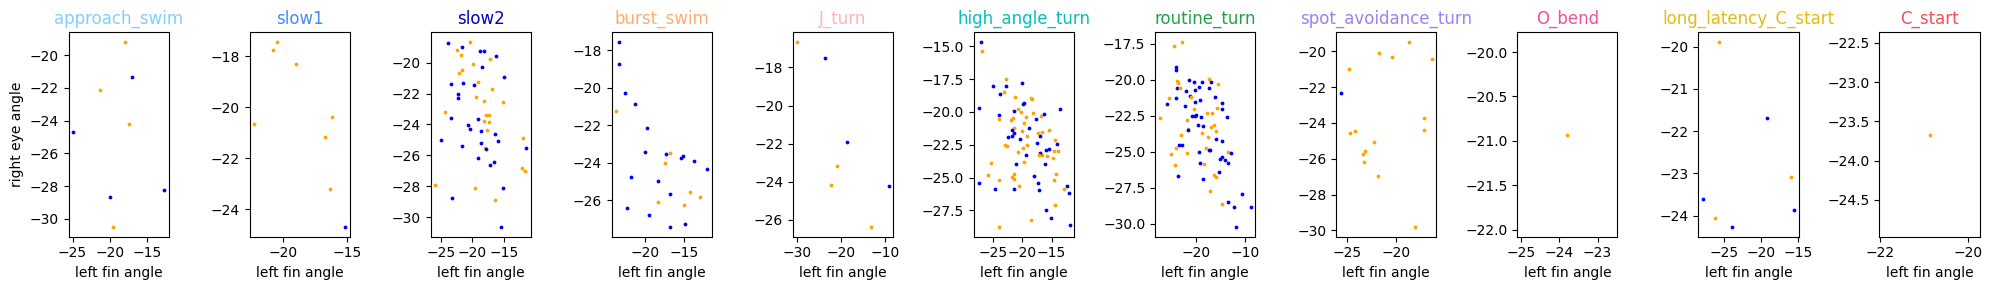

In [77]:
fig, axes = plt.subplots(1, 11, figsize=(20,3))#, sharex=True, sharey=True)
axes = axes.ravel()
size = 3
for i in range(11):
    for j in range(len(left_eye_angle_before_n[i])):
        axes[i].scatter(left_eye_angle_before_n[i][j][delta_body_angle_n[i][j]>0],right_eye_angle_before_n[i][j][delta_body_angle_n[i][j]>0],c='blue', s=size)
        axes[i].scatter(left_eye_angle_before_n[i][j][delta_body_angle_n[i][j]<0],right_eye_angle_before_n[i][j][delta_body_angle_n[i][j]<0],c='orange', s=size)
    axes[i].set_title(NameCat[i], color=color[i])
#     axes[i].set_xlim(-10,40)
#     axes[i].set_ylim(-10,40)
    axes[i].set_xlabel('left fin angle')
    
axes[0].set_ylabel('right eye angle')

plt.tight_layout()

fig.savefig(fish_paths[fish]/ 'eye_tail.png', dpi =300)

In [78]:
## Seperate L/R bouts before
delta_body_angle_n = []
left_eye_angle_before_n1 = []
right_eye_angle_before_n1 = []
bout_duration = 50

for cluster in range(11):
    delta_body_angle = []
    left_eye_angle_right_bout = []
    right_eye_angle_right_bout = []
    left_eye_angle_left_bout = []
    right_eye_angle_left_bout = []
    for i,on_ in enumerate(data['segments_on']):
            if (bout_cat[i]==cluster)&(data['outlier'][i]<3)&(data['proba'][i]>0.4)&(on_+bout_duration<data['body_angle'].shape[0]):
                delta_body_angle.append(data['body_angle'][on_+bout_duration]-data['body_angle'][on_])
                body_angle = np.array(data['body_angle'][on_+bout_duration]-data['body_angle'][on_])*180/np.pi
                if (body_angle >0):
                    left_eye_angle_right_bout.append(left_eye_angle[on_ :on_+bout_duration] -left_eye_angle[on_] )
                    right_eye_angle_right_bout.append(right_eye_angle[on_ :on_+bout_duration]- right_eye_angle[on_] )
                else:
                    left_eye_angle_left_bout.append(left_eye_angle[on_ :on_+bout_duration] -left_eye_angle[on_] )
                    right_eye_angle_left_bout.append(right_eye_angle[on_ :on_+bout_duration]- right_eye_angle[on_] )
    delta_body_angle = np.array(delta_body_angle)*180/np.pi
    delta_body_angle_n.append(delta_body_angle)
    left_eye_angle_before_n1.append([left_eye_angle_right_bout, left_eye_angle_left_bout])
    right_eye_angle_before_n1.append([right_eye_angle_right_bout, right_eye_angle_left_bout])
    

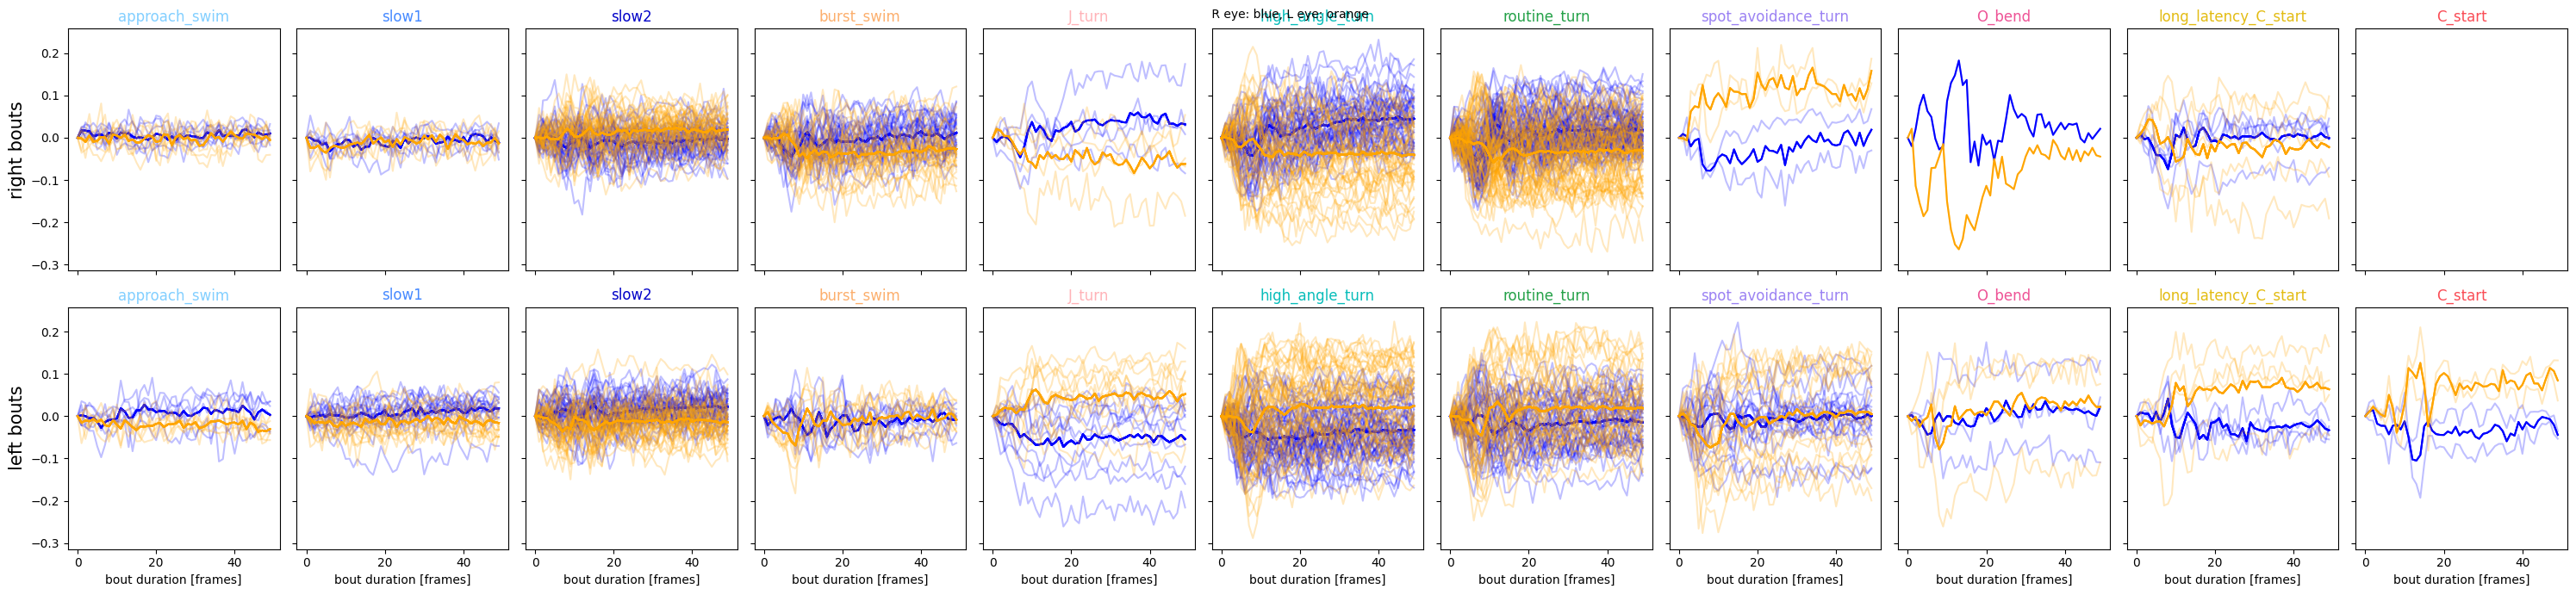

In [79]:
fig, axes = plt.subplots(2, 11, figsize=(30,7), sharex=True, sharey=True)
axes = axes.ravel()
size = 3
for i in range(11):
    right_boutsr = right_eye_angle_before_n1[i][0]
    right_boutsl = left_eye_angle_before_n1[i][0]
    for bout in right_boutsr:
        axes[i].plot(bout, alpha=0.25 , c='blue', label='right eye')
        axes[i].plot(np.mean(right_boutsr,axis=0), c='blue', label='right eye')
    for bout in right_boutsl:
        axes[i].plot(bout, alpha=0.25 , c='orange', label='left eye')
        axes[i].plot(np.mean(right_boutsl,axis=0), c='orange', label='right eye')
    
    axes[i].set_title(NameCat[i], color=color[i])
    
for i in range(11):
    left_boutsl = left_eye_angle_before_n1[i][1]
    left_boutsr = right_eye_angle_before_n1[i][1]
    for bout in left_boutsr:
        axes[i + 11].plot(bout, alpha=0.25 , c='blue', label='right eye')
        axes[i + 11].plot(np.mean(left_boutsr,axis=0), c='blue', label='right eye')
    for bout in left_boutsl:
        axes[i + 11].plot(bout, alpha=0.25 , c='orange', label='left eye')
        axes[i + 11].plot(np.mean(left_boutsl,axis=0), c='orange', label='right eye')
    axes[i + 11].set_title(NameCat[i], color=color[i])
    axes[i + 11].set_xlabel('bout duration [frames]')
    

axes[0].set_ylabel('right bouts', fontsize=15)
axes[11].set_ylabel('left bouts', fontsize=15)

plt.tight_layout()
fig.suptitle(' R eye: blue, L eye: orange', fontsize=10)

fig.savefig(fish_paths[fish]/ 'eye_turn_pereye.png', dpi = 300)


## Todos from meeting (30/03/2023):

    * Check rotation compensation (during turn) -> does it temporally evolve?
    * Check eye motion change during bout 
    * Check eye motion for consequitive bouts (evolution in time)-> is there a goal that lasts more than one bout?
    * plot delta eye vs delta body per bout cat
    * plot bvout type per initial eye pos (clustering)
    * matrix of eye cluster vs bout cluster (clustering)
    

In [80]:
# delta body and delta eye
delta_body_angle_n = []
left_eye_angle_delta_n = []
right_eye_angle_delta_n = []
bout_duration = 50

for cluster in range(11):
    delta_body_angle = []
    left_eye_angle_delta = []
    right_eye_angle_delta = []
    for i,on_ in enumerate(data['segments_on']):
            if (bout_cat[i]==cluster)&(data['outlier'][i]<3)&(data['proba'][i]>0.4)&(on_+bout_duration<data['body_angle'].shape[0]):
                delta_body_angle.append(data['body_angle'][on_+bout_duration]-data['body_angle'][on_])
                left_eye_angle_delta.append(data['eye_angles'][0][on_+bout_duration]-data['eye_angles'][0][on_])
                right_eye_angle_delta.append(data['eye_angles'][1][on_+bout_duration]-data['eye_angles'][1][on_])
    delta_body_angle = np.array(delta_body_angle)*180/np.pi
    left_eye_angle_delta = np.array(left_eye_angle_delta)*180/np.pi
    right_eye_angle_delta = np.array(right_eye_angle_delta)*180/np.pi
    delta_body_angle_n.append(delta_body_angle)
    left_eye_angle_delta_n.append(left_eye_angle_delta)
    right_eye_angle_delta_n.append(right_eye_angle_delta)



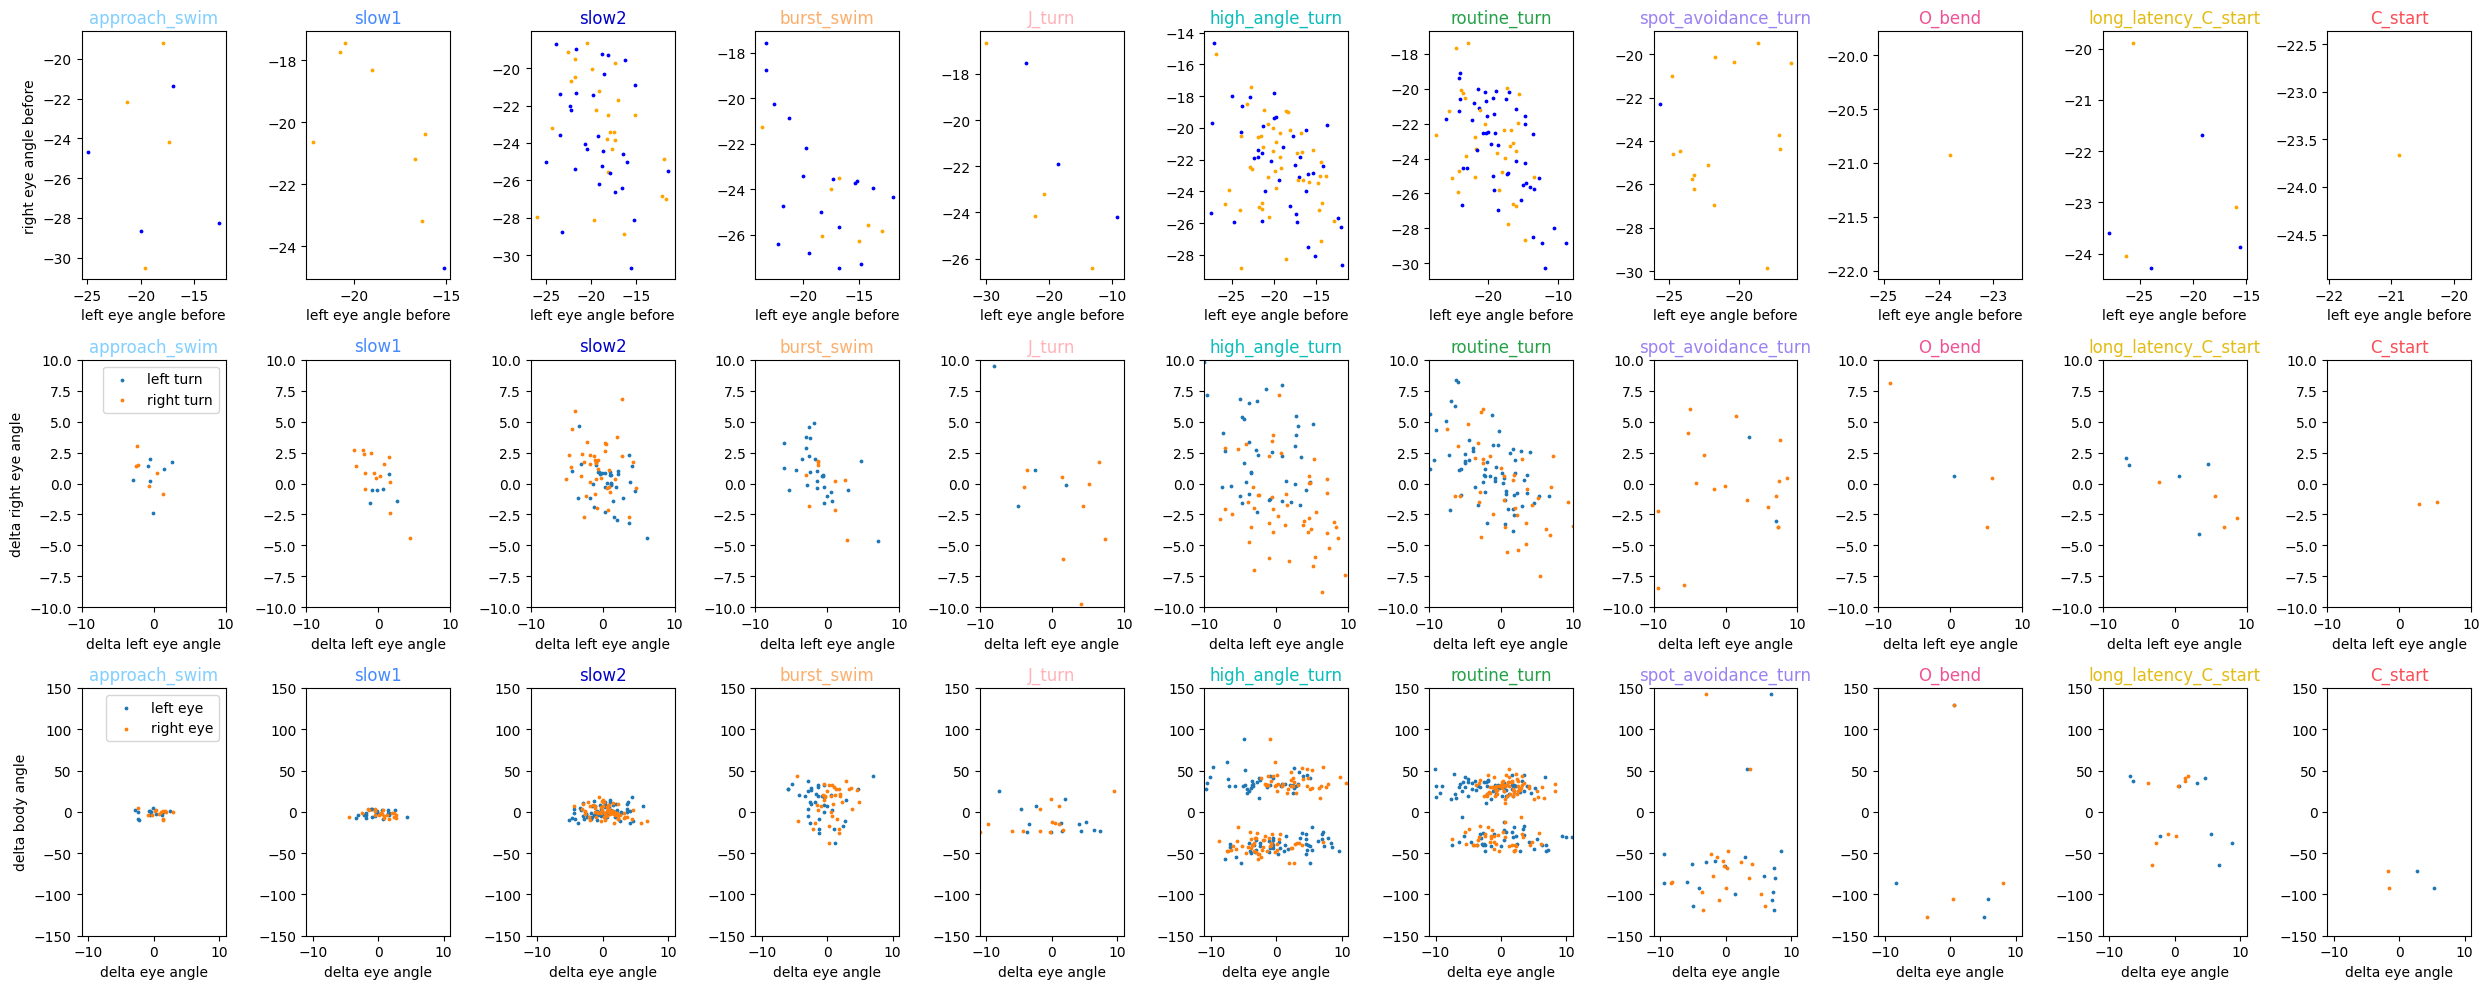

In [85]:
## Master eye plot?
n_cat = 11
fig, axes = plt.subplots(3, 11, figsize=(25,10))
axes = axes.ravel()
size = 3
for i in range(n_cat):
    for j in range(len(left_eye_angle_before_n[i])):
        axes[i].scatter(left_eye_angle_before_n[i][j][delta_body_angle_n[i][j]>0],right_eye_angle_before_n[i][j][delta_body_angle_n[i][j]>0], c='blue', s=size, label='left turn')
        axes[i].scatter(left_eye_angle_before_n[i][j][delta_body_angle_n[i][j]<0],right_eye_angle_before_n[i][j][delta_body_angle_n[i][j]<0], c='orange', s=size, label='right turn')
        axes[i].set_title(NameCat[i], color=color[i])
#     axes[i].set_xlim(-10,40)
#     axes[i].set_ylim(-10,40)
    axes[i].set_xlabel('left eye angle before')
    
for i in range(n_cat):
    axes[i + n_cat].scatter(left_eye_angle_delta_n[i][delta_body_angle_n[i]>0],right_eye_angle_delta_n[i][delta_body_angle_n[i]>0], s=size, label='left turn')
    axes[i + n_cat].scatter(left_eye_angle_delta_n[i][delta_body_angle_n[i]<0],right_eye_angle_delta_n[i][delta_body_angle_n[i]<0], s=size, label='right turn')
    axes[i + n_cat].set_title(NameCat[i], color=color[i])
    axes[i + n_cat].set_xlim(-10,10)
    axes[i + n_cat].set_ylim(-10,10)
    axes[i + n_cat].set_xlabel('delta left eye angle', fontsize=10)
    
for i in range(n_cat):
    axes[i + n_cat*2].scatter(left_eye_angle_delta_n[i], delta_body_angle_n[i], s=size, label='left eye')
    axes[i + n_cat*2].scatter(right_eye_angle_delta_n[i], delta_body_angle_n[i], s=size, label='right eye')
    axes[i + n_cat*2].set_title(NameCat[i], color=color[i])
    axes[i + n_cat*2].set_xlim(-11,11)
    axes[i + n_cat*2].set_ylim(-150,150)
    axes[i + n_cat*2].set_xlabel('delta eye angle', fontsize=10)

# axes[0].legend()    
axes[0].set_ylabel('right eye angle before', fontsize=10)
axes[0 + n_cat].set_ylabel('delta right eye angle', fontsize=10)
axes[0 + n_cat].legend()
axes[0 + n_cat*2].set_ylabel('delta body angle', fontsize=10)
axes[0 + n_cat*2].legend()

plt.tight_layout()

fig.savefig(fish_paths[fish]/ 'eye_tail_coor.png', dpi =300)


### Plot bout types used during experiment. Stucture?

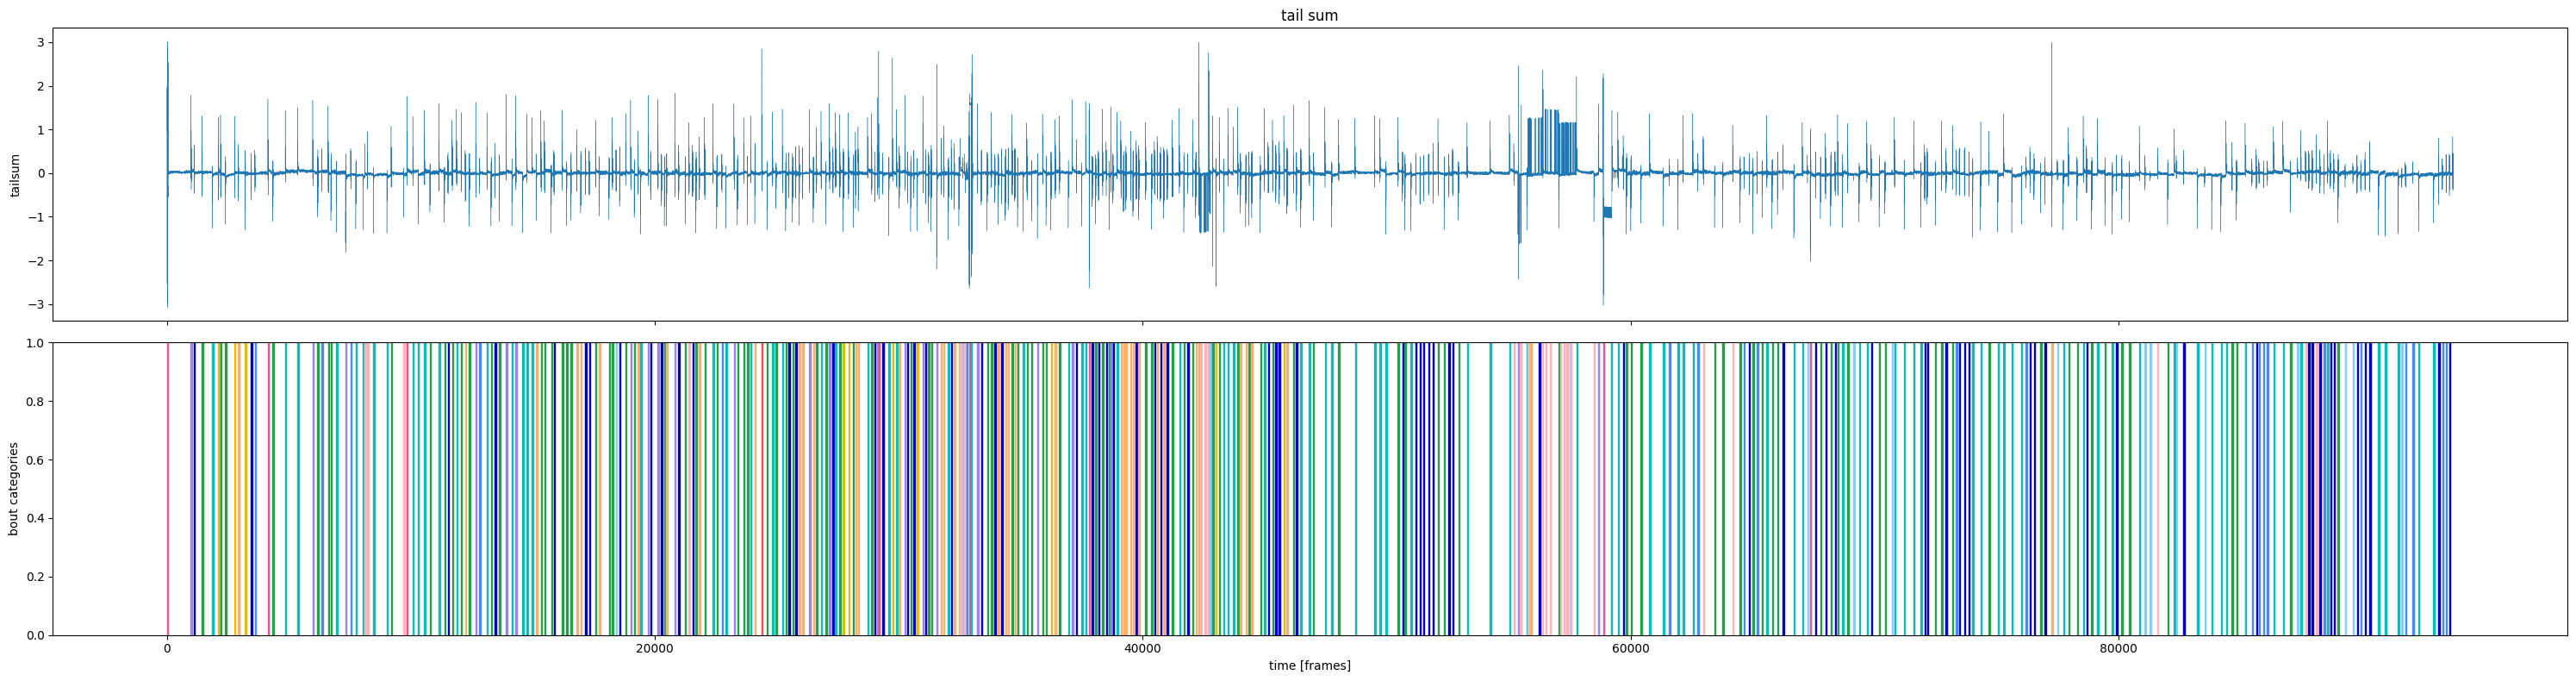

In [86]:
fig, axes = plt.subplots(2,1, figsize=(30,8), sharex = True)
axes = axes.ravel()

axes[0].plot(tailsum, lw=0.3)

for indx, onset in enumerate(data['segments_on']):
#     axes[1].axvline(onset, lw=0.5, ls=':', c='k')
    axes[1].axvspan(onset, onset+50, color=color[bout_cat[indx]])

axes[0].set_title('tail sum')
axes[1].set_xlabel('time [frames]')
axes[0].set_ylabel('tailsum')
axes[1].set_ylabel('bout categories')


# axes[0].set_xlim(60000,80000)

plt.tight_layout()
fig.savefig(fish_paths[fish]/ 'tail_cat.png', dpi =350)
# fig.savefig(fish_paths[fish]/ 'tail_cat_zoom.png', dpi =350)

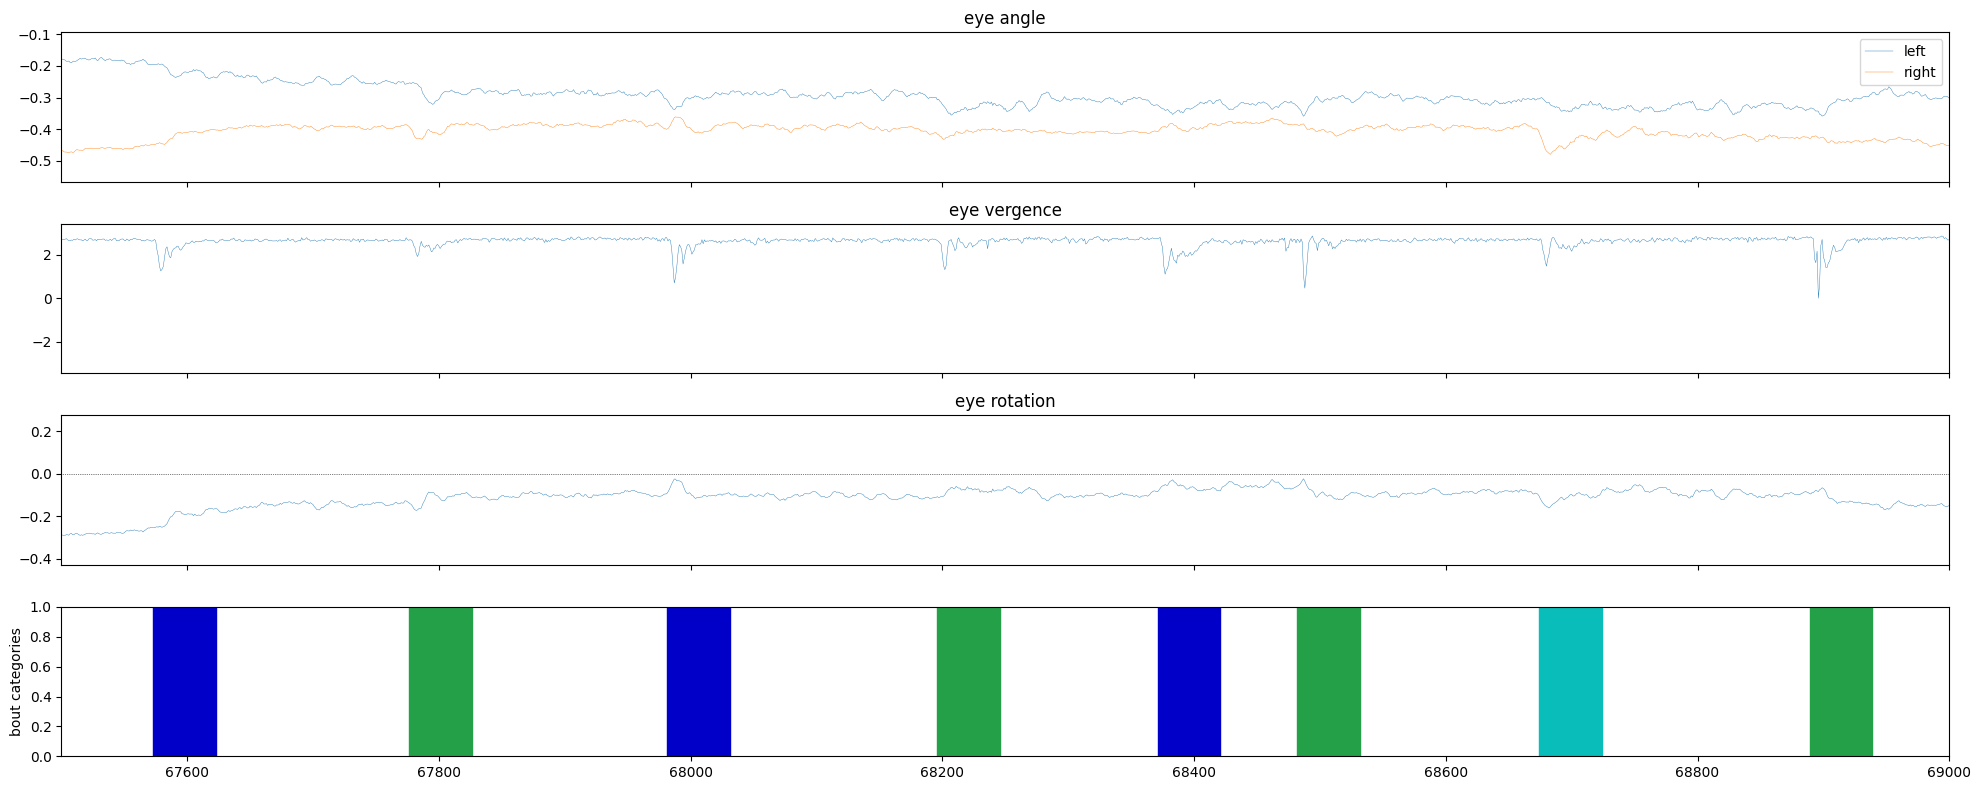

In [87]:
fig, axes = plt.subplots(4,1, figsize=(20,8), sharex = True)
axes = axes.ravel()
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
axes[0].plot(np.convolve(left_eye_angle, kernel, mode='same'), lw=0.3, label='left')
axes[0].plot(np.convolve(right_eye_angle, kernel, mode='same'), lw=0.3, label='right')
axes[1].plot(vergence, lw=0.3)
axes[2].plot(np.convolve(rotation_eye, kernel, mode='same'), lw=0.3)

for indx, onset in enumerate(data['segments_on']):
    axes[3].axvspan(onset, onset+50, color=color[bout_cat[indx]])
    
# axes[0].set_xlim(72500,75000) #turns (case 1)
axes[0].set_xlim(67500,69000) #straight bouts (case 2)

axes[0].set_title('eye angle')
axes[0].legend()
axes[1].set_title('eye vergence')
axes[2].set_title('eye rotation')
axes[2].axhline(0, ls=':', c='k', lw=0.5)
axes[3].set_ylabel('bout categories')

plt.tight_layout()

# fig.savefig(fish_paths[fish]/ 'tail_cat_case1.png', dpi =350)
fig.savefig(fish_paths[fish]/ 'tail_cat_case2.png', dpi =350)

In [88]:
#plot body angle vs eye rotation for consequitive bouts?
# delta body and delta eye
delta_body_angle_n = []
rotation_delta_n = []
bout_duration = 50

for cluster in range(11):
    delta_body_angle = []
    rotation_delta = []
    for i,on_ in enumerate(data['segments_on']):
            if (bout_cat[i]==cluster)&(data['outlier'][i]<3)&(data['proba'][i]>0.4)&(on_+bout_duration<data['body_angle'].shape[0]):
                delta_body_angle.append(data['body_angle'][on_+bout_duration]-data['body_angle'][on_])
                rotation_delta.append(rotation_eye[on_+bout_duration] - rotation_eye[on_])
    delta_body_angle = np.array(delta_body_angle)*180/np.pi
    rotation_delta = np.array(rotation_delta)*180/np.pi
    delta_body_angle_n.append(delta_body_angle)
    rotation_delta_n.append(rotation_delta)




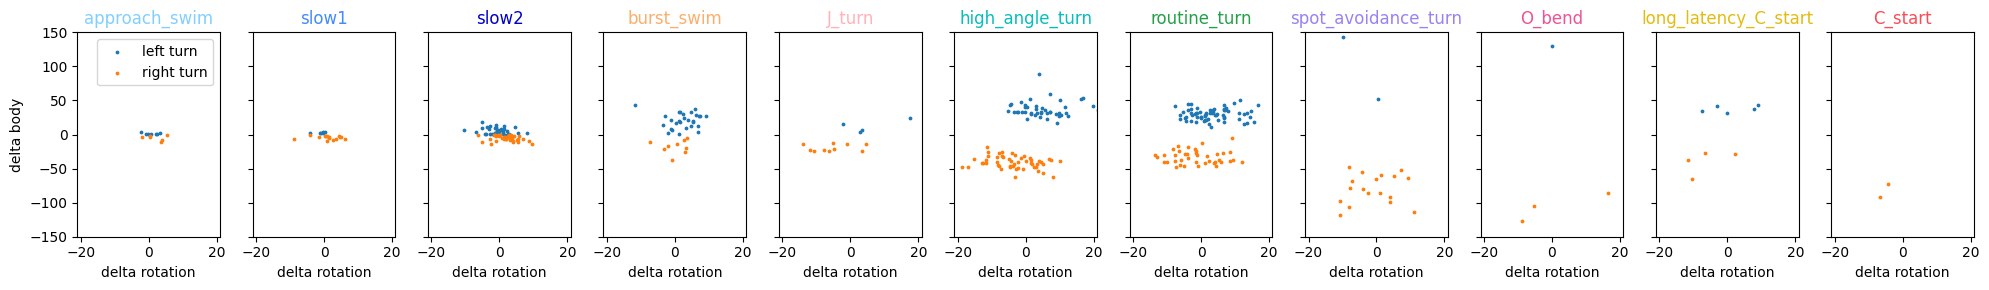

In [89]:
fig, axes = plt.subplots(1, 11, figsize=(20,3), sharex=True, sharey=True)
axes = axes.ravel()
size = 3
for i in range(11):
    axes[i].scatter(rotation_delta_n[i][delta_body_angle_n[i]>0], delta_body_angle_n[i][delta_body_angle_n[i]>0], s=size, label='left turn')
    axes[i].scatter(rotation_delta_n[i][delta_body_angle_n[i]<0], delta_body_angle_n[i][delta_body_angle_n[i]<0], s=size, label='right turn')
    axes[i].set_title(NameCat[i], color=color[i])
    axes[i].set_xlim(-21,21)
    axes[i].set_ylim(-150,150)
    axes[i].set_xlabel('delta rotation')
    
axes[0].set_ylabel('delta body')
axes[0].legend()
plt.tight_layout()

fig.savefig(fish_paths[fish]/ 'delta_eye_rot.png', dpi =300)

## plot body angle vs eye rotation for consequitive bouts?

In [90]:
#plot body angle vs eye rotation for consequitive bouts?
# delta body and delta eye
delta_body_angle_n = []
rotation_delta_n = []
bout_cat_n =[]
bout_duration = 50

delta_body_angle = []
rotation_delta = []
bout_ =[]
for i,on_ in enumerate(data['segments_on']):
        if (data['outlier'][i]<3)&(data['proba'][i]>0.4)&(on_+bout_duration<data['body_angle'].shape[0]):
            delta_body_angle.append(data['body_angle'][on_+bout_duration]-data['body_angle'][on_])
            rotation_delta.append(rotation_eye[on_+bout_duration] - rotation_eye[on_])
#             rotation_delta.append(rotation_eye[on_])
            bout_.append(data['bout_category_ts'][on_])
delta_body_angle = np.array(delta_body_angle)*180/np.pi
rotation_delta = np.array(rotation_delta)*180/np.pi
delta_body_angle_n.append(delta_body_angle)
rotation_delta_n.append(rotation_delta)
bout_cat_n.append(bout_)

In [91]:
# def slope(x1, y1, x2, y2):
#     return (y2-y1)/(x2-x1)

In [92]:
# test = np.vstack((rotation_delta_n[0], np.arange(0, len(rotation_delta_n[0]),1)))
# slopes = []
# for i in range(test[0].shape[0]-2):
#     slopes.append(slope(test[1][i], test[0][i], test[1][i+2],  test[0][i+2]))

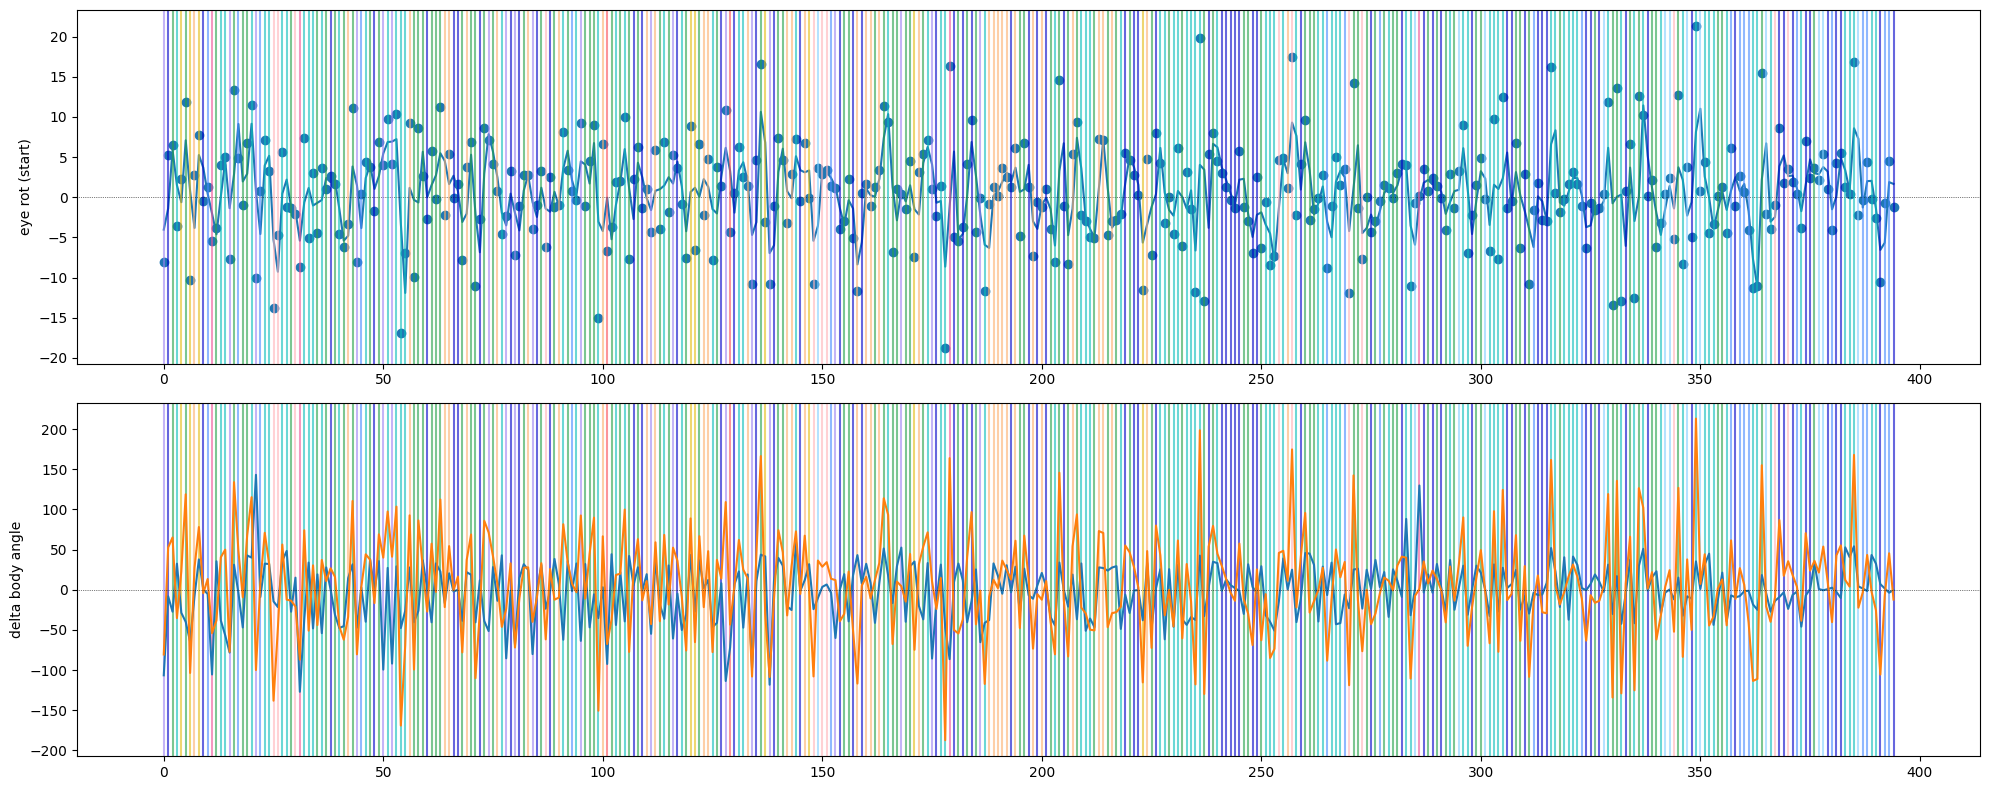

In [93]:
fig, axes = plt.subplots(2,1, figsize=(20,8))

kernel_size = 2
kernel = np.ones(kernel_size) / kernel_size
axes[0].scatter(np.arange(0, len(rotation_delta_n[0]),1), rotation_delta_n)
axes[0].plot(np.convolve(rotation_delta_n[0], kernel, mode='same'))
axes[0].axhline(0, lw=0.5, ls=':', c='k')

for indx in np.arange(0, len(rotation_delta_n[0]),1):
    axes[0].axvline(indx, color=color[int(bout_cat_n[0][indx])], alpha=0.6)    
    axes[1].axvline(indx, color=color[int(bout_cat_n[0][indx])], alpha=0.6)    

# axes[1].plot(np.diff(rotation_delta_n[0]))
# axes[1].plot(np.convolve(delta_body_angle_n[0], kernel, mode='same'))
axes[1].plot(delta_body_angle_n[0])
# axes[1].plot(np.convolve(delta_body_angle_n[0], kernel, mode='same'))
axes[1].plot(rotation_delta_n[0]*10)
# axes[1].plot(slopes)
axes[1].axhline(0, lw=0.5, ls=':', c='k')
axes[0].set_ylabel('eye rot (start)')
axes[1].set_ylabel('delta body angle')

plt.tight_layout()

fig.savefig(fish_paths[fish]/ 'eye_rot_cat', dpi =350)

In [94]:
# line intersection to find what fish is looking at
# eye convergence event and calculate backwards


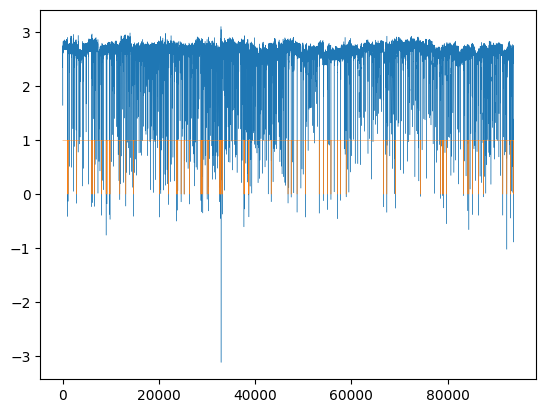

In [95]:
plt.figure()
plt.plot(vergence, lw=0.3)
plt.plot(vergence >=0, lw=0.3)

### Vector angle turned FINS


In [96]:
def distance(x1, y1, x2, y2):
    return np.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )

dist_befores =[]
dist_afters=[]

for i,on_ in enumerate(data['segments_on']):
        if (data['outlier'][i]<3)&(data['proba'][i]>0.4)&(on_+bout_duration<data['body_angle'].shape[0]):
            distance_left_fin = distance(left_fin_tip_x[on_], left_fin_tip_y[on_],body_x[on_], body_y[on_] )
            distance_right_fin = distance(right_fin_tip_x[on_], right_fin_tip_y[on_],body_x[on_], body_y[on_] )
            
            distance_left_fin_after = distance(left_fin_tip_x[on_ + bout_duration], left_fin_tip_y[on_ + bout_duration],body_x[on_ + bout_duration], body_y[on_ + bout_duration] )
            distance_right_fin_after = distance(right_fin_tip_x[on_ + bout_duration], right_fin_tip_y[on_ + bout_duration],body_x[on_ + bout_duration], body_y[on_ + bout_duration] )
            dist_befores.append([abs(distance_left_fin), abs(distance_right_fin)])
            dist_afters.append([abs(distance_left_fin_after), abs(distance_right_fin_after)])

            

NameError: name 'left_fin_tip_x' is not defined

In [ ]:
kp_tmp = np.zeros((len(dist_befores), 5))
kp_tmp[:, 0]= abs(np.asarray(vecto_angle_turned)) #delta body angle
kp_tmp[:, 1]= np.asarray(dist_befores)[:,0] #left fin pos before
kp_tmp[:, 2]= np.asarray(dist_befores)[:,1] #right fin pos before
kp_tmp[:, 3]= np.asarray(dist_afters)[:,0] #left fin pos after 
kp_tmp[:, 4]= np.asarray(dist_afters)[:,1] #right fin pos after 

kp_tmp

In [ ]:
kp_tmp = np.zeros((len(dist_befores), 7))
kp_tmp[:, 0]= np.zeros((len(dist_befores)))#abs(np.asarray(vecto_angle_turned))#np.zeros((len(dist_befores))) #delta body angle
kp_tmp[:, 1]= np.asarray(dist_befores)[:,0] #left fin pos before
kp_tmp[:, 2]= np.asarray(dist_befores)[:,1] #right fin pos before
kp_tmp[:, 3]= np.asarray(dist_afters)[:,0] #left fin pos after 
kp_tmp[:, 4]= np.asarray(dist_afters)[:,1] #right fin pos after
kp_tmp[:, 5]= abs(np.asarray(delta_ea)[:,0]) 
kp_tmp[:, 6]= abs(np.asarray(delta_ea)[:,1]) 


kp_tmp

kp_tmp = np.zeros((len(dist_befores), 7))
kp_tmp[:, 0]= abs(np.asarray(vecto_angle_turned))#np.zeros((len(dist_befores))) #delta body angle
kp_tmp[:, 1]= np.asarray(dist_befores)[:,0] #left fin pos before
kp_tmp[:, 2]= np.asarray(dist_befores)[:,1] #right fin pos before
kp_tmp[:, 3]= np.asarray(dist_afters)[:,0] #left fin pos after 
kp_tmp[:, 4]= np.asarray(dist_afters)[:,1] #right fin pos after
kp_tmp[:, 5]= abs(np.asarray(delta_ea)[:,0]) 
kp_tmp[:, 6]= abs(np.asarray(delta_ea)[:,1]) 


kp_tmp

In [ ]:
kp_tmp = np.zeros((len(dist_befores), 5))
kp_tmp[:, 0]= abs(np.asarray(vecto_angle_turned))#np.zeros((len(dist_befores))) #delta body angle
kp_tmp[:, 1]= np.asarray(dist_afters)[:,0] - np.asarray(dist_befores)[:,0] #left fin pos delta
kp_tmp[:, 2]= np.asarray(dist_afters)[:,1] - np.asarray(dist_befores)[:,1] #right fin pos delta
kp_tmp[:, 3]= abs(np.asarray(delta_ea)[:,0]) 
kp_tmp[:, 4]= abs(np.asarray(delta_ea)[:,1]) 


kp_tmp

In [ ]:
NameCat3 = ['angle_turned', 'l_fin_before', 'r_fin_before', 'l_fin_after', 'r_fin_after', 'delta ea left', 'delta ea right' ]

# NameCat3 = ['angle_turned', 'l_fin_delta', 'r_fin_delta',  'delta ea left', 'delta ea right' ]

In [ ]:
kp_tmp.shape, kin_vector.shape

In [ ]:
pca = PCA(n_components=25) #Start by looking at the firts 25 PCs.
pca.fit(kin_vector)
#Define number of principal components based on the explained variance per PC above
n_components = 5
pca=PCA(n_components=n_components)
meanresps_pca=pca.fit_transform(kp_tmp)

#Select number of clusters and clusterize
n_clusters = 3
kmeans_kp_pca = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(kp_tmp)

components = pca.fit_transform(kp_tmp)
total_var = pca.explained_variance_ratio_.sum() * 100

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# loadings = pca.components_.T

# labels = {str(i): f"PC {i+1}" for i in range(components.shape[0])}
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
labels['color'] = 'delta ba' #'PCA labels' #'delta rotation' #'max_velo_tail' #'mean_tail_angle'#'bout cat'#'max body angle', 'delta ba'



fig = px.scatter_matrix(
    components,
    color= delta_ba, #mean_tail_angle, #abs(np.asarray(delta_ea)[:,0]), #delta_ba, #bout_cat_n[0],  #np.asarray(dist_afters)[:,1], # np.asarray(dist_befores)[:,0], #bout_cat_n[0], #, kmeans_kp_pca, #delta_ba, #delta_rotation, #max_velo_tail, #mean_tail_angle, #bout_cat_n[0], #max_ba, bout_cat_n[0], delta_ba
    dimensions=range(components.shape[1]),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False, showupperhalf=False)

fig.update_layout(
    width=1000,
    height=1000,
)


fig.show()

In [97]:
col_list = []
for i in range(n_components):
    col_list.append('PC_{}'.format(i))
    
loading_matrix = pd.DataFrame(loadings, columns=col_list, index=NameCat3)
loading_matrix.sort_values(by=['PC_0'], ascending=False).head(15)

NameError: name 'n_components' is not defined

In [98]:
harvest = pearson_regressors( kp_tmp,  kp_tmp)

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
xticks_= np.arange(0, len(NameCat3),1)
# plt.axhline(len(NameCatEye), c='r', lw=0.5)
# plt.axhline(len(NameCatEye)+len(NameCatTail), c='r', lw=0.5)
# plt.axvline(len(NameCatEye), c='r', lw=0.5)
# plt.axvline(len(NameCatEye)+len(NameCatTail), c='r', lw=0.5)

ax.set_title("pearson correlation of kin params")
fig.tight_layout()
plt.xticks(xticks_,NameCat3)
plt.yticks(xticks_,NameCat3)
ax.figure.colorbar(im, ax=ax)
plt.show()


fig.savefig(fish_paths[fish]/ 'pearson_corr_ef', dpi =350)

NameError: name 'pearson_regressors' is not defined

In [99]:
# Data manipulation
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

# Visualization
import plotly.express as px # for data visualization

# Skleran
from sklearn.manifold import LocallyLinearEmbedding as LLE # for LLE dimensionality reduction
from sklearn.manifold import Isomap # for Isomap dimensionality reduction

https://plotly.com/python/colorscales/


https://towardsdatascience.com/lle-locally-linear-embedding-a-nifty-way-to-reduce-dimensionality-in-python-ab5c38336107

In [103]:
y = np.arange(0, kp_tmp.shape[0], 1)

NameError: name 'kp_tmp' is not defined

In [104]:
colors_bouts = color

In [105]:
# Create a 3D scatter plot
def Plot3D(X, y, plot_name, col=y, colorscale='viridis'):
    fig = px.scatter_3d(None, 
                        x=X[:,0], y=X[:,1], z=X[:,2],
                        color=col,
                        color_continuous_scale= colorscale,
                        height=800, width=800,
                       )
    # Update chart looks
    fig.update_layout(title_text=plot_name,
                      showlegend=False,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=1.75, z=1)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, 
                                  line=dict(color='black', width=0.1)))
    fig.update(layout_coloraxis_showscale=True)
    
    return fig
    
    
#----------------------------------------------      
# Create a 2D scatter plot
def Plot2D(X, y, plot_name, col=y):
    # Create a scatter plot
    fig = px.scatter(None, x=X[:,0], y=X[:,1], 
                     labels={
                         "x": "Dimension 1",
                         "y": "Dimension 2",
                     },
                     opacity=1, color=col)

    # Change chart background color
    fig.update_layout(dict(plot_bgcolor = 'white'))

    # Update axes lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                     zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                     showline=True, linewidth=1, linecolor='black')

    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                     zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                     showline=True, linewidth=1, linecolor='black')

    # Set figure title
    fig.update_layout(title_text=plot_name)

    # Update marker size
    fig.update_traces(marker=dict(size=5,
                                 line=dict(color='black', width=0.3)))
    return fig

NameError: name 'y' is not defined

In [101]:
# Function for performing LLE and MLLE
def run_lle(num_neighbors, dims, mthd, data):
    # Specify LLE parameters
    embed_lle = LLE(n_neighbors=num_neighbors, # default=5, number of neighbors to consider for each point.
                    n_components=dims, # default=2, number of dimensions of the new space 
                    reg=0.001, # default=1e-3, regularization constant, multiplies the trace of the local covariance matrix of the distances.
                    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’, auto : algorithm will attempt to choose the best method for input data
                    #tol=1e-06, # default=1e-6, Tolerance for ‘arpack’ method. Not used if eigen_solver==’dense’.
                    #max_iter=100, # default=100, maximum number of iterations for the arpack solver. Not used if eigen_solver==’dense’.
                    method=mthd, # {‘standard’, ‘hessian’, ‘modified’, ‘ltsa’}, default=’standard’
                    #hessian_tol=0.0001, # default=1e-4, Tolerance for Hessian eigenmapping method. Only used if method == 'hessian'
                    modified_tol=1e-12, # default=1e-12, Tolerance for modified LLE method. Only used if method == 'modified'
                    neighbors_algorithm='auto', # {‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’, algorithm to use for nearest neighbors search, passed to neighbors.NearestNeighbors instance
                    random_state=42, # default=None, Determines the random number generator when eigen_solver == ‘arpack’. Pass an int for reproducible results across multiple function calls.
                    n_jobs=-1 # default=None, The number of parallel jobs to run. -1 means using all processors.
                   )
    # Fit and transofrm the data
    result = embed_lle.fit_transform(data)
    
    # Return results
    return result

#----------------------------------------------   
# Function for performing Isomap
def run_isomap(num_neighbors, dims, data):
    # Specify Isomap parameters
    embed_isomap = Isomap(n_neighbors=num_neighbors, n_components=dims, n_jobs=-1)
    
    # Fit and transofrm the data
    result = embed_isomap.fit_transform(data)
    
    # Return results
    return result

In [ ]:
######### Regular swiss roll #########

# Standard LLE on a regular swiss roll
std_lle_res=run_lle(num_neighbors=10, dims=3, mthd='standard', data=kp_tmp)

# Modified LLE on a regular swiss roll
mlle_res=run_lle(num_neighbors=10, dims=3, mthd='modified', data=kp_tmp)

# Isomap on a regular swiss roll
isomap_res=run_isomap(num_neighbors=10, dims=3, data=kp_tmp)


In [ ]:
time = np.arange(0, len(bout_cat_n[0]), 1)

In [ ]:
str_bout_cat= s = list(str(int(x)) for x in  bout_cat_n[0])

In [ ]:
bout_ends =[]
for bout in tailsums:
    test = abs(np.diff(bout)) >0.01
    bout_end = np.where(test[test==True])[0]
    if len(bout_end)<=1:
        print (bout_end)
        bout_ends.append(np.nan)
    else:
        bout_ends.append(np.max(bout_end))
#     bout_ends.append(bout_end[-1])


In [ ]:
plt.figure()
plt.scatter(bout_ends, vel)

In [ ]:
vel = np.asarray(max_velo_tail)
vel[vel>=0.7] = np.nan

In [ ]:
# delta_body_angle, np.asarray(dist_befores)[:,0], np.asarray(delta_ea)[:,1], np.asarray(dist_afters)[:,0]

In [ ]:
# Plot3D(mlle_res, y, 'MLLE',  col=bout_ends  , colorscale='Bluered')# col= time)# bout_cat_n[0])

# Plot3D(isomap_res, y, 'Isomap',  col=bout_ends  , colorscale='Bluered')# col= time)# bout_cat_n[0])


In [ ]:
Plot3D(isomap_res, y, 'Isomap',  col=delta_rotation  , colorscale='RdBu_r')# col= time)# bout_cat_n[0])
# Plot3D(mlle_res, y, 'MLLE',  col=delta_rotation  , colorscale='RdBu_r')# col= time)# bout_cat_n[0])


In [ ]:
Plot3D(isomap_res, y, 'Isomap',  col=np.asarray(dist_befores)[:,0] , colorscale='RdBu_r')# col= time)# bout_cat_n[0])
# Plot3D(mlle_res, y, 'MLLE',  col=np.asarray(dist_befores)[:,0] , colorscale='RdBu_r')# col= time)# bout_cat_n[0])




In [ ]:
test = np.asarray(dist_befores)[:,0]  +np.asarray(dist_befores)[:,1] 
test1 = np.asarray(dist_afters)[:,0]  +np.asarray(dist_afters)[:,1] 

In [ ]:
# Plot2D(std_lle_res, y, 'LLE')
Plot3D(mlle_res, y, 'MLLE', col=delta_ba, colorscale='RdBu')# bout_cat_color) #str_bout_cat) #bout_cat_n[0]) #delta_rotation)#time) #bout_cat_n[0])
Plot3D(isomap_res, y, 'Isomap',   col=delta_ba, colorscale='RdBu')# col= time)# bout_cat_n[0])kp_tmp[:, 1]
# Plot3D(mlle_res, y, 'MLLE', col=delta_ba, colorscale='RdBu')
# 

In [ ]:
# Plot2D(std_lle_res, y, 'LLE')
# Plot3D(mlle_res, y, 'MLLE', col= bout_cat_n[0], colorscale = [*colors_bouts]) #delta_body_angle) #delta_rotation)#time) #bout_cat_n[0])
Plot3D(isomap_res, y, 'Isomap', col= bout_cat_n[0], colorscale = [*colors_bouts]) # col= time)# bout_cat_n[0])

## Map to kinematic parameters 

    Vector per bout?

In [ ]:
cluster_n_vector =[]
body_angles_vector= []
eye_angles_vector= []
fin_angles_vector= []
tail_vectors =[]
max_vergence = []
delta_rotation =[]

bout_duration = 50

for i,on_ in enumerate(data['segments_on']):
        if (data['outlier'][i]<3)&(data['proba'][i]>0.4)&(on_+bout_duration<data['body_angle'].shape[0]):
            body_angles_vector.append((data['body_angle'][on_:on_+bout_duration]-data['body_angle'][on_])*180/np.pi)
            left_eye = left_eye_vect[0,on_ :on_+bout_duration] -left_eye_vect[0,on_] 
            right_eye = right_eye_vect[0,on_ :on_+bout_duration]- right_eye_vect[0,on_]
#             eye_angles_vector.append(np.concatenate([left_eye, right_eye]))
            eye_angles_vector.append([left_eye, right_eye])
            left_fin = left_fin_vect[0,on_ :on_+bout_duration] -left_fin_vect[0,on_] 
            right_fin = right_fin_vect[0,on_ :on_+bout_duration]- right_fin_vect[0,on_]
#             fin_angles_vector.append(np.concatenate([left_fin, right_fin]))
            fin_angles_vector.append([left_fin, right_fin])
            cluster_n_vector.append(data['bout_category_ts'][on_])
            tail_vectors.append(data['clean_data_tail'][on_: on_ + bout_duration])
            max_vergence.append(np.max(vergence[on_: on_ + bout_duration]))
            delta_rotation.append(rotation_eye[on_: on_ + bout_duration][-1]- rotation_eye[on_]*180/np.pi)
            
            

    Kinematic params from body angle
    * delta body angle
    * max body angle

In [ ]:
delta_ba = []
max_ba = []
for i in body_angles_vector:
    delta_ba.append(i[-1])
    max_ba.append(np.max(abs(i)))
    

In [ ]:
# plt.figure()
# plt.plot(delta_ba, lw=0.6)
# plt.plot(max_ba, lw=0.6)

    Kinematic params from tail angle
    * max velocity
    * tail amplitudes per segemnt
    * mean tail angle
    (* max bout freq)

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

from scipy.signal import hilbert, chirp

def hilbert_tbf(tailsum, fps):
    analytic_signal = hilbert(tailsum)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * fps)
    return instantaneous_frequency


def compute_tbf(tail_sum, dt, min_valid_tps=5, cut=8):
    """Estimate the instantaneous tail-beat frequency from the half-period of the tail oscillation.
    :param tail_sum: array of tracked tail angles
    :param dt: dt of the behavior array
    :param min_valid_tps: minimum array of valid timepoints within a bout to use in the TBF calculation
    :return: array with the tail-beat frequency.
    """

    idxs = np.arange(tail_sum.shape[0])
    tbf_output = np.full(idxs.shape[0], 0)

    min_idxs = []
    max_idxs = []

    for i in range(1, tail_sum.shape[0] - 1):
        if tail_sum[i - 1] < tail_sum[i] > tail_sum[i + 1]:
            max_idxs.append(i)
        elif tail_sum[i - 1] > tail_sum[i] < tail_sum[i + 1]:
            min_idxs.append(i)

    if len(min_idxs) == 0 or len(max_idxs) == 0:
        pass

    else:
        extrema = np.sort(
            np.concatenate((np.array(min_idxs), np.array(max_idxs)))
        )
        valid_idxs = idxs[
            np.logical_and(idxs >= min(extrema), idxs < max(extrema))
        ]

        extrema_cut = extrema[:cut]
        magnitudes = tail_sum[extrema_cut]

        if len(valid_idxs) > min_valid_tps:
            time_diffs = (
                np.array(
                    [x - extrema[i - 1] for i, x in enumerate(extrema)][1:]
                )
                * dt
            )
            binned_tps = np.digitize(valid_idxs, extrema) - 1
            instant_time_diff = np.array([time_diffs[i] for i in binned_tps])
            tbf = (1 / instant_time_diff) / 2
            tbf_output[valid_idxs[0] : valid_idxs[-1] + 1] = tbf

        else:
            pass

    return tbf_output, extrema_cut, magnitudes

In [ ]:
fps=200
dt = 1/fps
max_velo_tail =[]
mean_tail_angle = []
sparse_code_tail = []

tail_vectors = np.asarray(tail_vectors)
tailsums= np.zeros((tail_vectors.shape[0], tail_vectors.shape[1]))
for bout in range(tail_vectors.shape[0]):
    pre_tail= np.zeros((tail_vectors.shape[1], tail_vectors.shape[2]))
    for segment in range(tail_vectors.shape[2]):
        pre_tail[:, segment]= tail_vectors[bout][:, segment] -tail_vectors[bout][:, 0]
        pre_tailsum= np.sum(pre_tail, axis=1)/pre_tail.shape[0]
        tailsum = reduce_to_pi(pre_tailsum)
        tailsums[bout, :]= tailsum

for tailsum in tailsums:
    tbf_output, extrema_cut, magnitudes = compute_tbf(tailsum, dt, min_valid_tps=5)
    # instantaneous_frequency = hilbert_tbf(tailsum, fps)
    sparse_code_tail.append([extrema_cut, magnitudes])
    # tbf_tail.append(instantaneous_frequency)
    max_velo_tail.append(np.max(abs(np.diff(tailsum))))
    mean_tail_angle.append(np.mean(tailsum))
    


In [ ]:
len(max_velo_tail)

    Kinematic params for eyes

In [ ]:
delta_ea = []
max_ea = []
for i in eye_angles_vector:
    delta_ea.append([abs(i[0][-1]), abs(i[1][-1])])
    max_ea.append([np.max(abs(i[0])), np.max(abs(i[1]))])
    

    Kinematic params for fins

    Todo : add fin speed?
    
#### Lets look at some example bouts

In [ ]:
thr =2
fig, axes = plt.subplots(4,2, sharex=True )#, sharey=True)
axes= axes.ravel()
bout= 21
# for bout in range(1):
axes[0].plot(abs(np.diff(fin_angles_vector[bout][0])), c='blue', alpha= 0.3)
axes[1].plot(abs(np.diff(fin_angles_vector[bout][1])), c='orange', alpha= 0.3)

axes[2].plot(fin_angles_vector[bout][0], c='blue', alpha= 0.3)
axes[3].plot(fin_angles_vector[bout][1], c='orange', alpha= 0.3)

axes[4].plot(eye_angles_vector[bout][0], c='blue', alpha= 0.3)
axes[5].plot(eye_angles_vector[bout][1], c='orange', alpha= 0.3)

axes[6].plot(tail_vectors[bout]*10, c='black', alpha= 0.1)
axes[7].plot(tail_vectors[bout]*10, c='black', alpha= 0.1)
axes[6].plot(tailsums[bout]*100, c='black', alpha= 0.8)
axes[7].plot(tailsums[bout]*100, c='black', alpha= 0.8)

axes[2].axvline(np.argwhere(abs(fin_angles_vector[bout][0]) >= thr)[0][0], lw=0.8, ls=':', c='k')
axes[3].axvline(np.argwhere(abs(fin_angles_vector[bout][1]) >= thr)[0][0], lw=0.8, ls=':', c='k')
axes[4].axvline(np.argwhere(abs(eye_angles_vector[bout][0]) >= thr)[0][0], lw=0.8, ls=':', c='k')
axes[5].axvline(np.argwhere(abs(eye_angles_vector[bout][1]) >= thr)[0][0], lw=0.8, ls=':', c='k')
axes[6].axvline(np.argwhere(abs(tailsums[bout])*100 >= thr)[0][0], lw=0.8, ls=':', c='k')
axes[7].axvline(np.argwhere(abs(tailsums[bout])*100 >= thr)[0][0], lw=0.8, ls=':', c='k')

# axes[0].plot(np.mean(abs(np.diff(fin_angles_vector[0:10][0])), axis=0), c='k')
# axes[1].plot(np.mean(abs(np.diff(fin_angles_vector[0:10][1])), axis=0), c='k')
    
axes[0].set_title('left')
axes[1].set_title('right')
axes[0].set_ylabel('fin velo')
axes[2].set_ylabel('fin vector')
axes[4].set_ylabel('eye vector')
axes[6].set_ylabel('tail vector')

fig.suptitle(NameCat[int(np.asarray(bout_cat_n[0])[bout])], color=color[cluster])

In [ ]:
delta_fa = []
max_fa = []
sparse_code_fin = []

for i in fin_angles_vector:
    delta_fa.append([abs(i[0][-1]), abs(i[1][-1])])
    max_fa.append([np.max(abs(i[0])), np.max(abs(i[1]))])
    
for i in range(len(fin_angles_vector)):
    tbf_outputl, extrema_cutl, magnitudesl = compute_tbf(np.asarray(fin_angles_vector[i][0]), dt, min_valid_tps=5, cut=12)
    tbf_outputr, extrema_cutr, magnitudesr = compute_tbf(np.asarray(fin_angles_vector[i][1]), dt, min_valid_tps=5, cut=12)
    sparse_code_fin.append([extrema_cutl, magnitudesl, extrema_cutr, magnitudesr])
    
    

### Pool kinematic params 
    
    max_vergence (1)
    delta_rotation (1)
    delta_ea (L, R 2)
    max_ea (L, R 2)
    delta_ba (1)
    max_ba (1)
    max_velo_tail (1)
    mean_tail_angle  (1)
    sparse_code_tail (8)
    delta_fa (L, R, 2)
    max_fa (L, R, 2)
    sparse_code_fin (L, R, 12)

In [ ]:
NameCatEye= ['max_vergence',
    'delta_rotation',
    'delta_ea_left',
    'max_ea_left', 
    'delta_ea_right',
    'max_ea_right']
NameCatTail = [
    'delta_ba',
    'max_ba',
    'max_velo_tail',
    'mean_tail_angle', 
    'maxima_tail_1',
    'maxima_tail_2',
    'maxima_tail_3',
    'maxima_tail_4',
    'maxima_tail_5',
    'maxima_tail_6',
    'maxima_tail_7',
    'maxima_tail_8',
    'loc_maxima_tail_1',
    'loc_maxima_tail_2',
    'loc_maxima_tail_3',
    'loc_maxima_tail_4',
    'loc_maxima_tail_5',
    'loc_maxima_tail_6',
    'loc_maxima_tail_7',
    'loc_maxima_tail_8' 
]
NameCatFins =[
    'delta_fa_left',
    'max_fa_left',
    'delta_fa_right',
    'max_fa_right',
    'maxima_left_fin_1',
    'maxima_left_fin_2',
    'maxima_left_fin_3',
    'maxima_left_fin_4',
    'maxima_left_fin_5',
    'maxima_left_fin_6',
    'maxima_left_fin_7',
    'maxima_left_fin_8',
    'loc_maxima_left_fin_1',
    'loc_maxima_left_fin_2',
    'loc_maxima_left_fin_3',
    'loc_maxima_left_fin_4',
    'loc_maxima_left_fin_5',
    'loc_maxima_left_fin_6',
    'loc_maxima_left_fin_7',
    'loc_maxima_left_fin_8',
    'maxima_right_fin_1',
    'maxima_right_fin_2',
    'maxima_right_fin_3',
    'maxima_right_fin_4',
    'maxima_right_fin_5',
    'maxima_right_fin_6',
    'maxima_right_fin_7',
    'maxima_right_fin_8',
    'loc_maxima_right_fin_1',
    'loc_maxima_right_fin_2',
    'loc_maxima_right_fin_3',
    'loc_maxima_right_fin_4',
    'loc_maxima_right_fin_5',
    'loc_maxima_right_fin_6',
    'loc_maxima_right_fin_7',
    'loc_maxima_right_fin_8' ]

In [53]:
NameCat2 = NameCatEye + NameCatTail + NameCatFins
len(NameCat2)

# NameCat2 = NameCatEye + NameCatFins
# len(NameCat2)

NameError: name 'NameCatEye' is not defined

    Todo: dont forget to z score

In [54]:
temp_eye = np.zeros((len(eye_angles_vector), len(NameCatEye)))    
temp_eye.shape

for bout in range(len(eye_angles_vector)):
    temp_eye[bout, 0] = nanzscore(max_vergence[bout])
    temp_eye[bout, 1] = nanzscore(delta_rotation[bout])
    temp_eye[bout, 2] = nanzscore(delta_ea[bout][0])
    temp_eye[bout, 3] = nanzscore(max_ea[bout][0])
    temp_eye[bout, 4] = nanzscore(delta_ea[bout][1])
    temp_eye[bout, 5] = nanzscore(max_ea[bout][1])

NameError: name 'eye_angles_vector' is not defined

In [55]:
nanzscore(sparse_code_tail[0][0])

NameError: name 'sparse_code_tail' is not defined

In [103]:
temp_tail = np.zeros((len(eye_angles_vector), len(NameCatTail)))    
temp_tail.shape

for bout in range(len(eye_angles_vector)):
    temp_tail[bout, 0] = nanzscore(delta_ba[bout])
    temp_tail[bout, 1] = nanzscore(max_ba[bout])
    temp_tail[bout, 2] = nanzscore(max_velo_tail[bout])
    temp_tail[bout, 3] =nanzscore( mean_tail_angle[bout])

    for j in range(8):
        temp_max = nanzscore(sparse_code_tail[bout][1])
        temp_loc= nanzscore(sparse_code_tail[bout][1])
        temp_tail[bout, 4 + j] =temp_max[j]
        temp_tail[bout, 12 + j] =temp_loc[j]
        

In [104]:
temp_fin = np.zeros((len(eye_angles_vector), len(NameCatFins)))    
temp_fin.shape

for bout in range(len(eye_angles_vector)):
    temp_fin[bout, 0] = nanzscore(delta_fa[bout][0])
    temp_fin[bout, 1] = nanzscore(max_fa[bout][0])
    temp_fin[bout, 2] = nanzscore(delta_fa[bout][1])
    temp_fin[bout, 3] = nanzscore(max_fa[bout][1])

    for j in range(8):
        temp_max_left  = nanzscore(sparse_code_fin[bout][1])
        temp_loc_left  = nanzscore(sparse_code_fin[bout][1])
        temp_max_right  = nanzscore(sparse_code_fin[bout][1])
        temp_loc_right  = nanzscore(sparse_code_fin[bout][1])
        
        temp_fin[bout, 4 + j] = temp_max_left[j] #left)
        temp_fin[bout, 12 + j] = temp_loc_left[j] #left)
        temp_fin[bout, 20 + j] = temp_max_right[j] #right)
        temp_fin[bout, 28 + j] = temp_loc_right[j] #right)


In [105]:
NameCat2 = NameCatEye + NameCatTail + NameCatFins
print(NameCat2[2:7], NameCat2[25:30])

kin_vector = np.zeros((len(eye_angles_vector), len(NameCat2)))    

for bout in range(len(eye_angles_vector)):
    kin_vector[bout, :len(NameCatEye)]= temp_eye[bout]
    kin_vector[bout, len(NameCatEye):len(NameCatEye) +len(NameCatTail)]= temp_tail[bout]
    kin_vector[bout, len(NameCatEye) +len(NameCatTail):]= temp_fin[bout]

['delta_ea_left', 'max_ea_left', 'delta_ea_right', 'max_ea_right', 'delta_ba'] ['loc_maxima_tail_8', 'delta_fa_left', 'max_fa_left', 'delta_fa_right', 'max_fa_right']


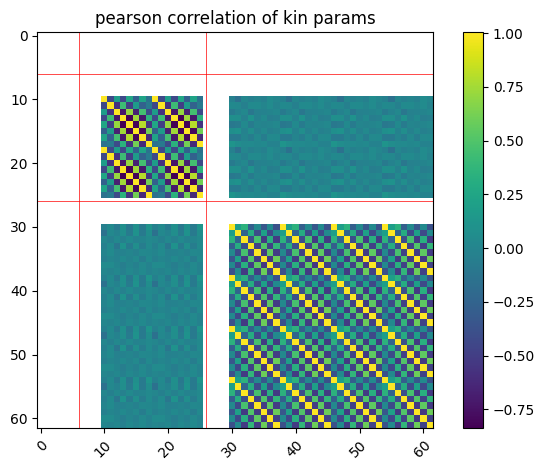

In [106]:
harvest = pearson_regressors( kin_vector,  kin_vector)

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.axhline(len(NameCatEye), c='r', lw=0.5)
plt.axhline(len(NameCatEye)+len(NameCatTail), c='r', lw=0.5)
plt.axvline(len(NameCatEye), c='r', lw=0.5)
plt.axvline(len(NameCatEye)+len(NameCatTail), c='r', lw=0.5)

ax.set_title("pearson correlation of kin params")
fig.tight_layout()
ax.figure.colorbar(im, ax=ax)
plt.show()


fig.savefig(fish_paths[fish]/ 'pearson_corr', dpi =350)

In [107]:
NameCatEye

['max_vergence',
 'delta_rotation',
 'delta_ea_left',
 'max_ea_left',
 'delta_ea_right',
 'max_ea_right']

In [108]:
NameCatFins

['delta_fa_left',
 'max_fa_left',
 'delta_fa_right',
 'max_fa_right',
 'maxima_left_fin_1',
 'maxima_left_fin_2',
 'maxima_left_fin_3',
 'maxima_left_fin_4',
 'maxima_left_fin_5',
 'maxima_left_fin_6',
 'maxima_left_fin_7',
 'maxima_left_fin_8',
 'loc_maxima_left_fin_1',
 'loc_maxima_left_fin_2',
 'loc_maxima_left_fin_3',
 'loc_maxima_left_fin_4',
 'loc_maxima_left_fin_5',
 'loc_maxima_left_fin_6',
 'loc_maxima_left_fin_7',
 'loc_maxima_left_fin_8',
 'maxima_right_fin_1',
 'maxima_right_fin_2',
 'maxima_right_fin_3',
 'maxima_right_fin_4',
 'maxima_right_fin_5',
 'maxima_right_fin_6',
 'maxima_right_fin_7',
 'maxima_right_fin_8',
 'loc_maxima_right_fin_1',
 'loc_maxima_right_fin_2',
 'loc_maxima_right_fin_3',
 'loc_maxima_right_fin_4',
 'loc_maxima_right_fin_5',
 'loc_maxima_right_fin_6',
 'loc_maxima_right_fin_7',
 'loc_maxima_right_fin_8']

In [96]:
NameCat2 = NameCatEye + NameCatFins
len(NameCat2)

kin_vector = np.zeros((len(eye_angles_vector), len(NameCat2)))    

for bout in range(len(eye_angles_vector)):
    kin_vector[bout, :len(NameCatEye)]= temp_eye[bout]
#     kin_vector[bout, len(NameCatEye):len(NameCatEye) +len(NameCatTail)]= temp_tail[bout]
    kin_vector[bout, len(NameCatEye):]= temp_fin[bout]

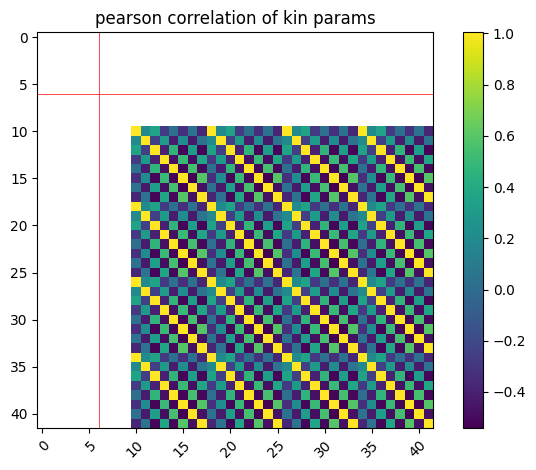

In [97]:
harvest = pearson_regressors( kin_vector,  kin_vector)

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.axhline(len(NameCatEye), c='r', lw=0.5)
plt.axvline(len(NameCatEye), c='r', lw=0.5)

ax.set_title("pearson correlation of kin params")
fig.tight_layout()
ax.figure.colorbar(im, ax=ax)
plt.show()

In [1003]:
kin_vector[0].shape

(42,)

In [1009]:
######### Regular swiss roll #########

# Standard LLE on a regular swiss roll
std_lle_res=run_lle(num_neighbors=15, dims=5, mthd='standard', data=kin_vector)

# Modified LLE on a regular swiss roll
mlle_res=run_lle(num_neighbors=15, dims=5, mthd='modified', data=kin_vector)

# Isomap on a regular swiss roll
isomap_res=run_isomap(num_neighbors=15, dims=5, data=kin_vector)


In [1036]:
# Plot3D(std_lle_res, y, 'LLE', col=delta_ba, colorscale='RdBu')
Plot3D(mlle_res, y, 'MLLE',  col=kin_vector[:,2], colorscale='RdBu')
# Plot3D(isomap_res, y, 'Isomap', col=delta_ba, colorscale='RdBu')



In [1013]:
# Plot3D(std_lle_res, y, 'LLE', col= bout_cat_n[0], colorscale = [*colors_bouts]) 
Plot3D(mlle_res, y, 'MLLE', col= bout_cat_n[0], colorscale = [*colors_bouts]) 
# Plot3D(isomap_res, y, 'Isomap', col= bout_cat_n[0], colorscale = [*colors_bouts]) 



## Cluster based on kinematic params

In [1015]:
#Perform PCA
pca = PCA(n_components=25) #Start by looking at the firts 25 PCs.
pca.fit(kin_vector)

PCA(n_components=25)

In [1016]:
# #Plot the cumulative explained variance by the main PCs.
# x=np.arange(0,25,1)
# expl_var=np.cumsum(pca.explained_variance_ratio_)

# fig = plt.figure()
# plt.plot(x, expl_var)
# plt.xlabel('Principal Components')
# plt.ylabel('Explained Variance')
# plt.grid()
# plt.show()
#fig.savefig('expl_var_batch4_png')

In [1017]:
#Define number of principal components based on the explained variance per PC above
n_components = 25
pca=PCA(n_components=n_components)
meanresps_pca=pca.fit_transform(kin_vector)

In [1018]:
#Make elbow plot to choose optimal size of clusters
# distorsions = []

# for k in range(1, 25):
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(fins_comb) #Computes the clustering
#     distorsions.append(kmeans.inertia_) #Appends the inertia attirbute of the fit: Sum of squared distances of samples to their closest cluster center.

# figu = plt.figure(figsize=(10, 5))
# plt.plot(range(1,25), distorsions)
# plt.grid(True)
# plt.title('Elbow curve')

In [1019]:
#Select number of clusters and clusterize
n_clusters = 15
kmeans_kp_pca = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(kin_vector)

#### Visualize PCA

In [1020]:
import plotly.express as px

In [95]:
def smart_conv(array1, array2):
    return np.convolve(array1, array2)[:array1.shape[0]]


def pearson_regressors(traces, regressors):
    """ Gives the pearson correlation coefficient
    :param traces: the regressors, with time in rows
    :param regressors: the regressors, with time in rows
    :return: the pearson correlation coefficient
    """
    # two versions, depending whether there is one or multiple regressors
    X = traces
    Y = regressors
    if len(Y.shape) == 1:
        numerator = np.dot(X.T, Y) - X.shape[0] * np.nanmean(X, 0) * np.nanmean(Y)
        denominator = (X.shape[0] - 1) * np.nanstd(X, 0) * np.nanstd(Y)
        result = numerator / denominator
    else:
        numerator = np.dot(X.T, Y) - X.shape[0] * np.outer(np.nanmean(X, 0),
                                                           np.nanmean(Y, 0))
        denominator = (X.shape[0] - 1) * np.outer(np.nanstd(X, 0),
                                                  np.nanstd(Y, 0))
        result = (numerator / denominator).T

    return result

def cross_correlation(traces, nanfraction_thr=0.5):
    """ Function to calculate reliability of cell responses.
        Reliability is defined as the average of the across-trials correlation.
        This measure seems to generally converge after a number of 7-8 repetitions, so it
        is advisable to have such a repetition number to use it.
        :param traces:
        :return:
        """

    reliability = np.zeros(traces.shape[0])
    for i in range(len(reliability)):
        trace = traces[i, :, :]
        sel_trace = trace[:, np.sum(np.isnan(trace), 0) != trace.shape[0]]

        if nanfraction_thr is not None:
            if np.sum(np.isnan(sel_trace)) > nanfraction_thr * sel_trace.size:
                reliability[i] = 0
            else:
                corr = np.corrcoef(sel_trace)
                np.fill_diagonal(corr, np.nan)
                reliability[i] = np.nanmean(corr)

    return reliability


In [1022]:
print(NameCat2)

['max_vergence', 'delta_rotation', 'delta_ea_left', 'max_ea_left', 'delta_ea_right', 'max_ea_right', 'delta_fa_left', 'max_fa_left', 'delta_fa_right', 'max_fa_right', 'maxima_left_fin_1', 'maxima_left_fin_2', 'maxima_left_fin_3', 'maxima_left_fin_4', 'maxima_left_fin_5', 'maxima_left_fin_6', 'maxima_left_fin_7', 'maxima_left_fin_8', 'loc_maxima_left_fin_1', 'loc_maxima_left_fin_2', 'loc_maxima_left_fin_3', 'loc_maxima_left_fin_4', 'loc_maxima_left_fin_5', 'loc_maxima_left_fin_6', 'loc_maxima_left_fin_7', 'loc_maxima_left_fin_8', 'maxima_right_fin_1', 'maxima_right_fin_2', 'maxima_right_fin_3', 'maxima_right_fin_4', 'maxima_right_fin_5', 'maxima_right_fin_6', 'maxima_right_fin_7', 'maxima_right_fin_8', 'loc_maxima_right_fin_1', 'loc_maxima_right_fin_2', 'loc_maxima_right_fin_3', 'loc_maxima_right_fin_4', 'loc_maxima_right_fin_5', 'loc_maxima_right_fin_6', 'loc_maxima_right_fin_7', 'loc_maxima_right_fin_8']


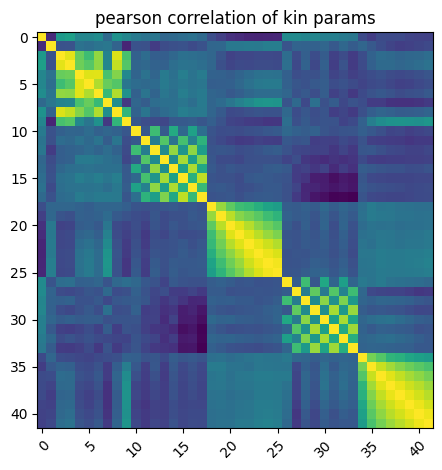

In [1023]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


harvest = pearson_regressors( kin_vector,  kin_vector)


fig, ax = plt.subplots()
im = ax.imshow(harvest)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("pearson correlation of kin params")
fig.tight_layout()
plt.show()

In [1024]:
res=[]
for i in range(len(NameCat2)):
    res.append(pearson_regressors( kin_vector[:,6],  kin_vector[:,i]))

In [1025]:
len(res), np.where(abs(np.asarray(res))>=0.7), NameCat2[4],  NameCat2[5],  NameCat2[6],  NameCat2[8]

(42,
 (array([2, 3, 4, 5, 6, 8], dtype=int64),),
 'delta_ea_right',
 'max_ea_right',
 'delta_fa_left',
 'delta_fa_right')

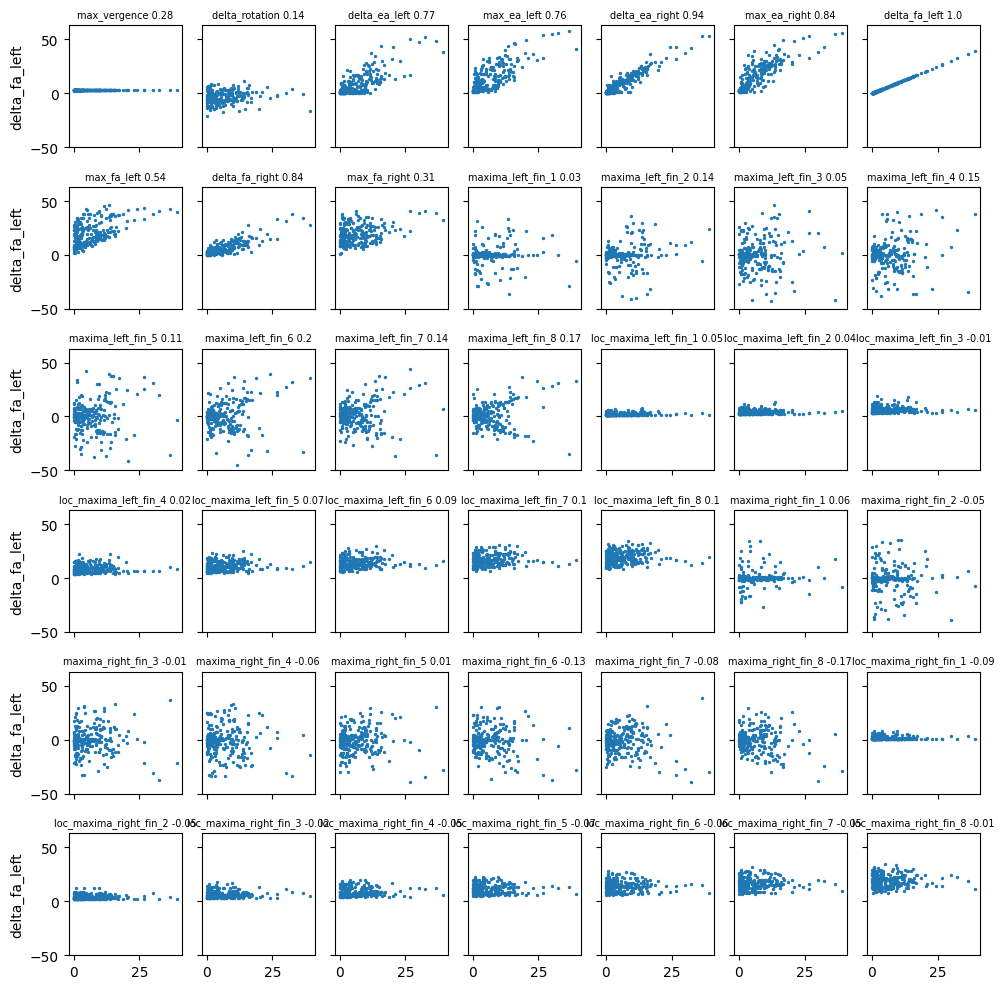

In [1026]:
fig, axes = plt.subplots(6,7, figsize=(10,10), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(len(NameCat2)):
    axes[i].scatter(kin_vector[:,6],  kin_vector[:,i], s=2)
    axes[i].set_title('{} {}'.format(NameCat2[i], np.round(res[i], 2)), fontsize=7)

axes[0].set_ylabel('delta_fa_left')
axes[7].set_ylabel('delta_fa_left')
axes[14].set_ylabel('delta_fa_left')
axes[21].set_ylabel('delta_fa_left')
axes[28].set_ylabel('delta_fa_left')
axes[35].set_ylabel('delta_fa_left')
    
plt.tight_layout()

fig.savefig(fish_paths[fish]/ 'scatter_eye_fin', dpi =350)

In [1027]:
NameCat2[6], NameCat2[15], NameCat2[31],  NameCat2[5], NameCat2[3]

('delta_fa_left',
 'maxima_left_fin_6',
 'maxima_right_fin_6',
 'max_ea_right',
 'max_ea_left')

In [1028]:
pca = PCA(n_components=25) #Start by looking at the firts 25 PCs.
pca.fit(kin_vector)
#Define number of principal components based on the explained variance per PC above
n_components = 5
pca=PCA(n_components=n_components)
meanresps_pca=pca.fit_transform(kin_vector)

#Select number of clusters and clusterize
n_clusters = 16
kmeans_kp_pca = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(kin_vector)

components = pca.fit_transform(kin_vector)
total_var = pca.explained_variance_ratio_.sum() * 100

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# loadings = pca.components_.T

# labels = {str(i): f"PC {i+1}" for i in range(components.shape[0])}
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
labels['color'] = 'bout cat' #'PCA labels' #'delta rotation' #'max_velo_tail' #'mean_tail_angle'#'bout cat'#'max body angle', 'delta ba'



fig = px.scatter_matrix(
    components,
    color=bout_cat_n[0],# kin_vector[:,5], #bout_cat_n[0], # kin_vector[:,9], #delta_rotation, #delta_ba, #bout_cat_n[0], #, kmeans_kp_pca, #delta_ba, #delta_rotation, #max_velo_tail, #mean_tail_angle, #bout_cat_n[0], #max_ba, bout_cat_n[0], delta_ba
    dimensions=range(components.shape[1]),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False, showupperhalf=False)

fig.update_layout(
    width=1000,
    height=1000,
)


fig.show()

In [1029]:
len(mean_tail_angle), 

(242,)

In [1030]:
loadings.shape

(42, 5)

In [1031]:
col_list = []
for i in range(n_components):
    col_list.append('PC_{}'.format(i))


In [1034]:
loading_matrix = pd.DataFrame(loadings, columns=col_list, index=NameCat2)
loading_matrix.sort_values(by=['PC_1'], ascending=False).head(15)

PC_0       PC_1      PC_2      PC_3      PC_4
max_ea_right        4.363108  10.164404  0.350376  1.040071  1.910303
max_ea_left         3.890128   9.961127  2.304051 -1.902954 -0.863755
delta_ea_right      3.787380   8.317208  0.952832  0.772342  0.891314
delta_ea_left       2.996423   8.084112  2.083354 -1.295842 -0.539085
delta_fa_left       2.494121   5.617026  0.775011  0.247103  0.292269
max_fa_left         2.627815   5.509090 -0.973516  2.152814  3.546862
delta_fa_right      2.283441   4.990439  1.042790 -0.327019 -0.110710
maxima_right_fin_5 -5.894498   3.516070 -4.111000 -2.753662 -6.020802
max_fa_right        0.753201   3.440691  2.238011 -1.811393 -0.565279
maxima_right_fin_4 -7.504674   3.256086 -7.144576  3.392874  4.272626
maxima_right_fin_3 -5.445095   3.181585 -4.372386 -2.351974 -7.437425
maxima_right_fin_7 -6.234227   2.584533 -4.589384 -2.097337 -5.531571
maxima_right_fin_6 -7.563292   2.318805 -6.058692  2.699174  2.291272
maxima_right_fin_2 -4.807062   1.940973 -5.835540  4.013436  3.402615
maxima_right_fin_8 -6.717111   1.778373 -5.458119  2.030374  1.318284

    TODO: check delta vs max angles -> same? are my kinematic params well chosen?

#### kmeans_kp_pca plots

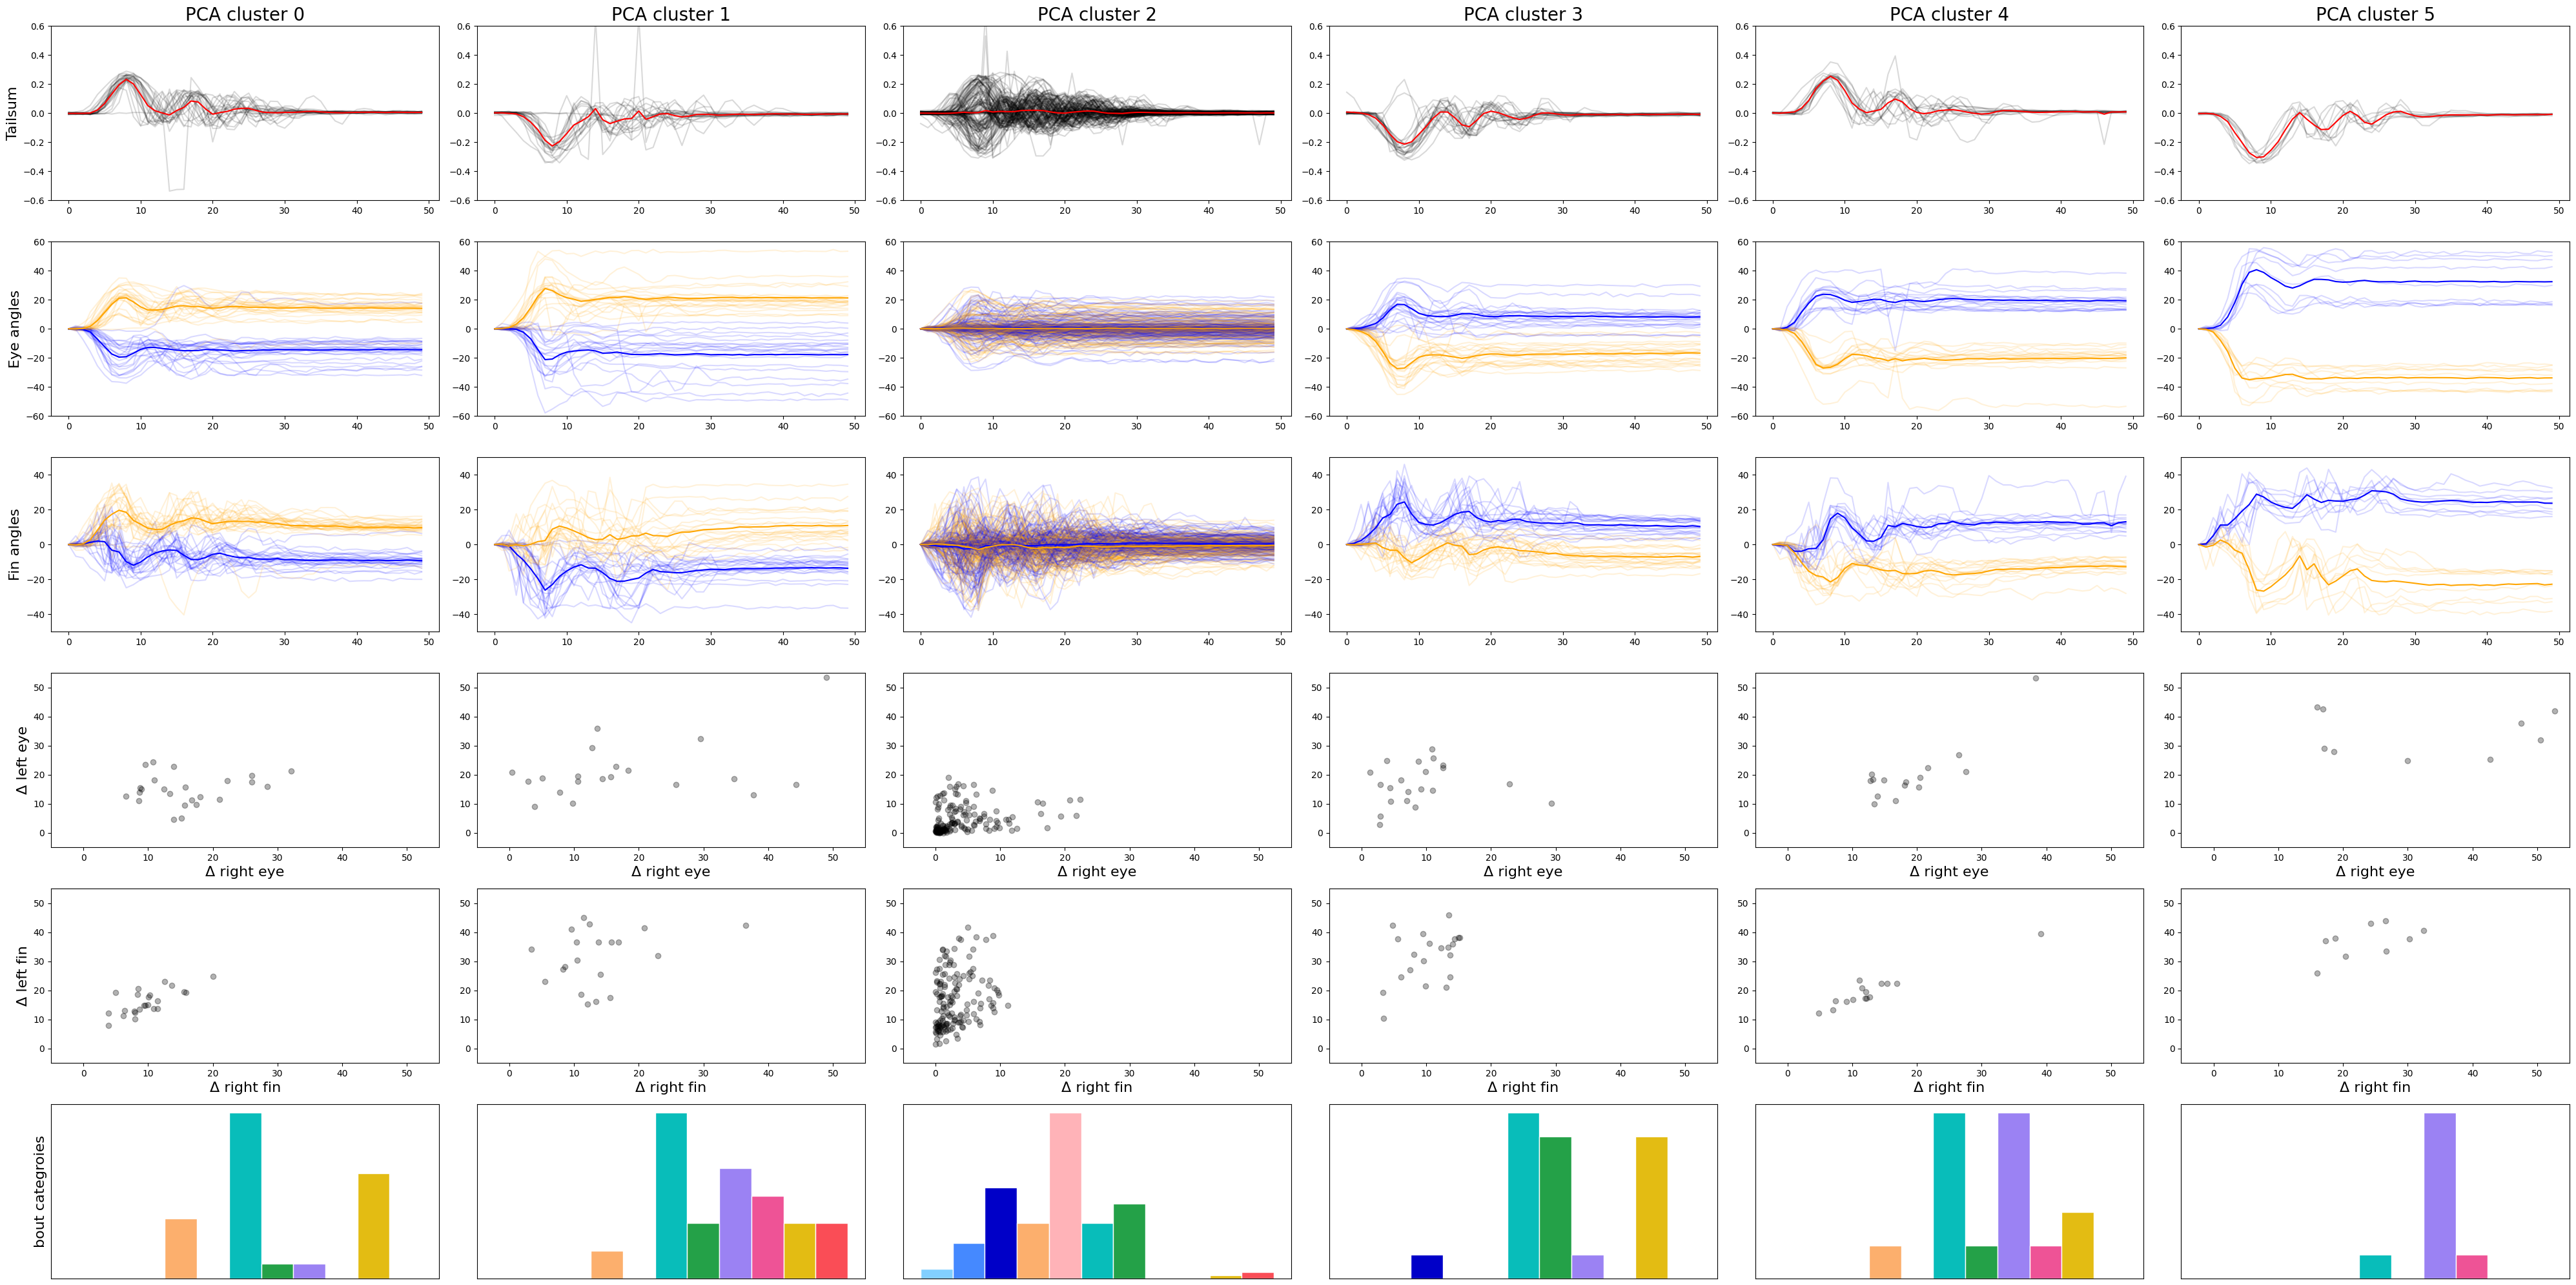

In [91]:
fsize= 16
alpha_val =0.15

fig, axes = plt.subplots(6, n_clusters, figsize=(40, 20)) #, sharex=True, sharey=True)
axes= axes.ravel()

for j in range(n_clusters):
    for i in range(tailsums[kmeans_kp_pca ==j].shape[0]):
        axes[j].plot(tailsums[kmeans_kp_pca ==j][i], alpha=alpha_val, c='k')
    axes[j].plot(np.mean(tailsums[kmeans_kp_pca ==j], axis=0), c='red')
    axes[j].set_ylim(-0.6,0.6)
        
    for i in range(np.asarray(eye_angles_vector)[kmeans_kp_pca ==j].shape[0]):
        axes[j + n_clusters].plot(np.asarray(eye_angles_vector)[kmeans_kp_pca ==j][i][0], alpha=alpha_val, c='blue')
        axes[j + n_clusters].plot(np.asarray(eye_angles_vector)[kmeans_kp_pca ==j][i][1], alpha=alpha_val, c='orange')
    axes[j + n_clusters].plot(np.mean(np.asarray(eye_angles_vector)[kmeans_kp_pca ==j][:,0], axis=0), c='blue',  label='left')
    axes[j + n_clusters].plot(np.mean(np.asarray(eye_angles_vector)[kmeans_kp_pca ==j][:,1], axis=0), c='orange',  label='right')
    axes[j + n_clusters].set_ylim(-60,60)

    for i in range(np.asarray(fin_angles_vector)[kmeans_kp_pca ==j].shape[0]):
        axes[j + n_clusters*2].plot(np.asarray(fin_angles_vector)[kmeans_kp_pca ==j][i][0], alpha=alpha_val, c='blue')
        axes[j + n_clusters*2].plot(np.asarray(fin_angles_vector)[kmeans_kp_pca ==j][i][1], alpha=alpha_val, c='orange')
    axes[j + n_clusters*2].plot(np.mean(np.asarray(fin_angles_vector)[kmeans_kp_pca ==j][:,0], axis=0), c='blue',  label='left')
    axes[j + n_clusters*2].plot(np.mean(np.asarray(fin_angles_vector)[kmeans_kp_pca ==j][:,1], axis=0), c='orange',  label='right')
    axes[j + n_clusters*2].set_ylim(-50,50)

    for i in range(temp_eye[kmeans_kp_pca ==j].shape[0]):
        axes[j + n_clusters*3].scatter(temp_eye[kmeans_kp_pca ==j][i][2], temp_eye[kmeans_kp_pca ==j][i][4],alpha=alpha_val*2, c='k')
        axes[j + n_clusters*3].set_xlim(-5,55)
        axes[j + n_clusters*3].set_ylim(-5,55)
        axes[j + n_clusters*3].set_xlabel('Δ right eye', fontsize=fsize)
        
    for i in range(temp_fin[kmeans_kp_pca ==j].shape[0]):
        axes[j + n_clusters*4].scatter(temp_fin[kmeans_kp_pca ==j][i][0], temp_fin[kmeans_kp_pca ==j][i][1],alpha=alpha_val*2, c='k')
        axes[j + n_clusters*4].set_xlim(-5,55)
        axes[j + n_clusters*4].set_ylim(-5,55)
        axes[j + n_clusters*4].set_xlabel('Δ right fin', fontsize=fsize)
         
            
    n, bins, patches = axes[j + n_clusters*5].hist(np.asarray(bout_cat_n[0])[kmeans_kp_pca==j], bins=np.arange(0,12,1),
                        density=False, edgecolor='white', linewidth=1)
    axes[j + n_clusters*5].set_yticks([])
    axes[j + n_clusters*5].set_xticks([])
    for j in range(len(bins)-1):
        patches[j].set_facecolor(color[j])
            
#     axes[j + n_clusters*6].hist(np.asarray(delta_ba)[kmeans_kp_pca==j])
#     axes[j + n_clusters*6].set_yticks([])
#         axes[j + n_clusters*6].set_xticks([])
        
        
for j in range(n_clusters):
    axes[j].set_title('PCA cluster {}'.format(j), fontsize=fsize+4)
axes[0].set_ylabel('Tailsum', fontsize=fsize)
axes[0 + n_clusters].set_ylabel('Eye angles', fontsize=fsize)
axes[0 + n_clusters*2].set_ylabel('Fin angles', fontsize=fsize)
axes[0 + n_clusters*3].set_ylabel('Δ left eye', fontsize=fsize)
axes[0 + n_clusters*4].set_ylabel('Δ left fin', fontsize=fsize)
axes[0 + n_clusters*5].set_ylabel('bout categroies', fontsize=fsize)
# axes[0 + n_clusters*6].set_ylabel('Δ bout angle', fontsize=fsize)

# axes[0 + n_clusters].legend()
# axes[0 + n_clusters*2].legend()

plt.tight_layout()

fig.savefig(fish_paths[fish]/'kp_clustering_{}.png'.format(n_clusters), dpi = 300)


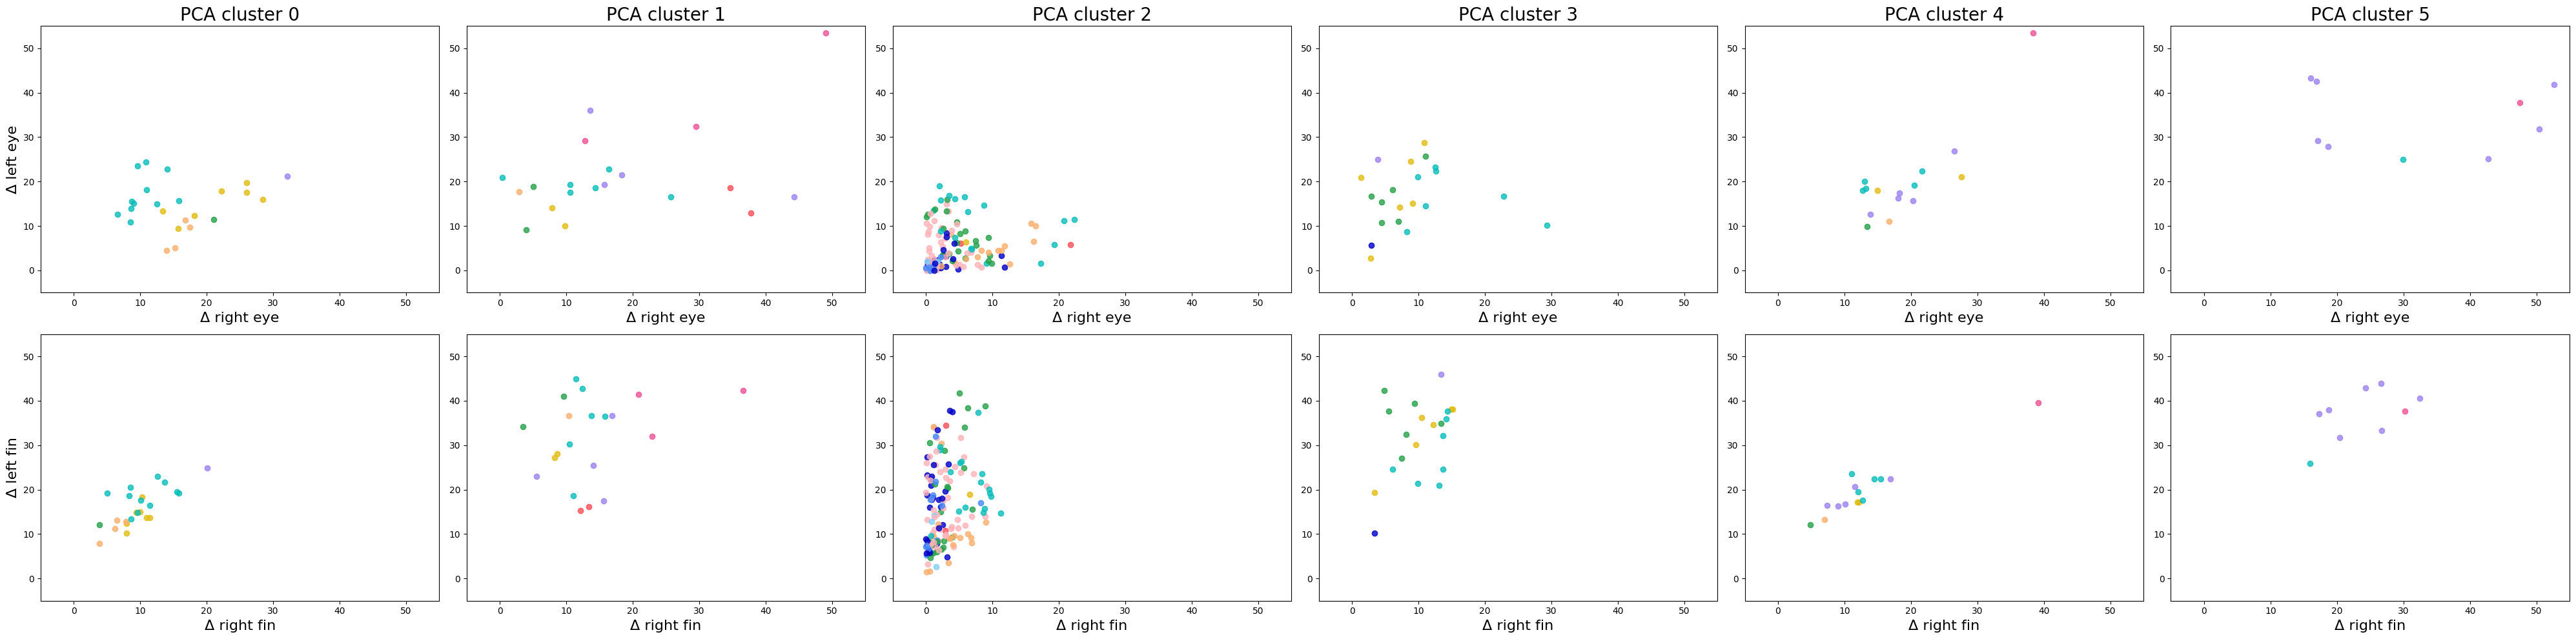

In [92]:
fig, axes = plt.subplots(2, n_clusters, figsize=(40, 10)) #, sharex=True, sharey=True)
axes= axes.ravel()

for j in range(n_clusters):
    for i in range(temp_eye[kmeans_kp_pca ==j].shape[0]):
        col_clust= color[int(np.asarray(bout_cat_n[0])[kmeans_kp_pca ==j][i])]
        axes[j].scatter(temp_eye[kmeans_kp_pca ==j][i][2], temp_eye[kmeans_kp_pca ==j][i][4],alpha=0.8, c=col_clust)
        axes[j].set_xlim(-5,55)
        axes[j].set_ylim(-5,55)
        axes[j].set_xlabel('Δ right eye', fontsize=fsize)
        
    for i in range(temp_fin[kmeans_kp_pca ==j].shape[0]):
        col_clust= color[int(np.asarray(bout_cat_n[0])[kmeans_kp_pca ==j][i])]
        axes[j + n_clusters].scatter(temp_fin[kmeans_kp_pca ==j][i][0], temp_fin[kmeans_kp_pca ==j][i][1],alpha=0.8, c=col_clust)
        axes[j + n_clusters].set_xlim(-5,55)
        axes[j + n_clusters].set_ylim(-5,55)
        axes[j + n_clusters].set_xlabel('Δ right fin', fontsize=fsize)

for j in range(n_clusters):
    axes[j].set_title('PCA cluster {}'.format(j), fontsize=fsize+4)
axes[0].set_ylabel('Δ left eye', fontsize=fsize)
axes[0 + n_clusters].set_ylabel('Δ left fin', fontsize=fsize)

plt.tight_layout()

fig.savefig(fish_paths[fish]/'kp_clustering_cat_{}.png'.format(n_clusters), dpi = 300)


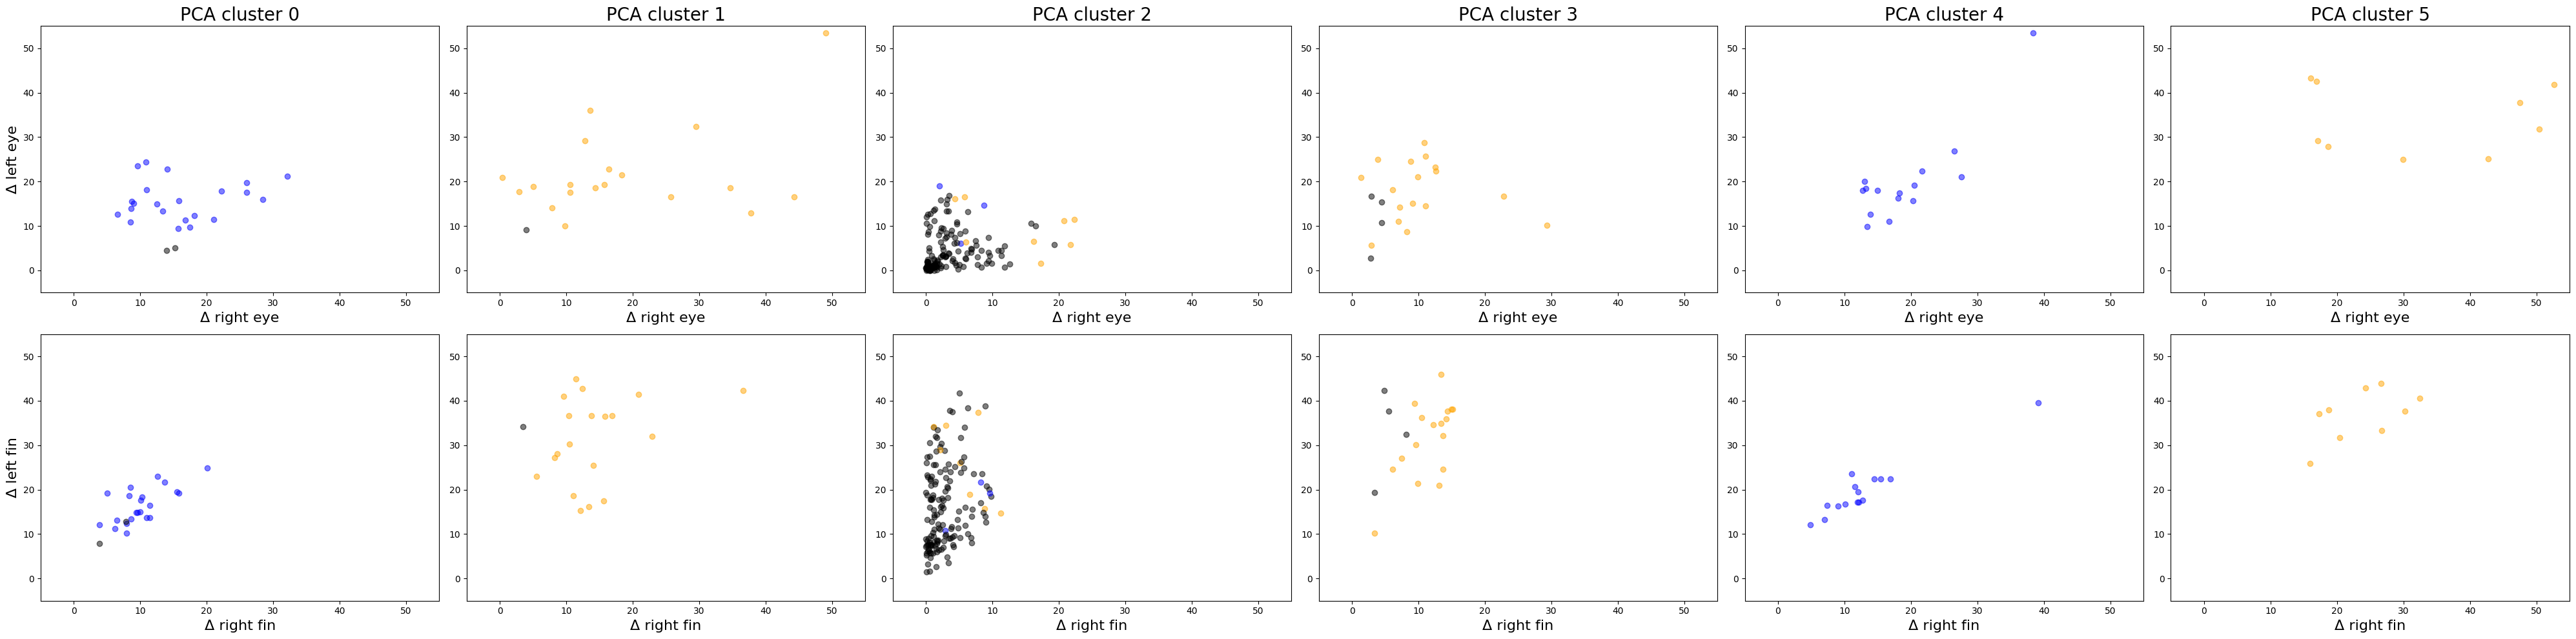

In [93]:
ba_cutoff = 25
fig, axes = plt.subplots(2, n_clusters, figsize=(40, 10)) #, sharex=True, sharey=True)
axes= axes.ravel()

for j in range(n_clusters):
    for i in range(temp_eye[kmeans_kp_pca ==j].shape[0]):
        ba= np.asarray(delta_ba)[kmeans_kp_pca==j][i]
        if ba >=ba_cutoff: 
            axes[j].scatter(temp_eye[kmeans_kp_pca ==j][i][2], temp_eye[kmeans_kp_pca ==j][i][4],alpha=0.5, c='orange')#right ba
        if ba <=-ba_cutoff:
            axes[j].scatter(temp_eye[kmeans_kp_pca ==j][i][2], temp_eye[kmeans_kp_pca ==j][i][4],alpha=0.5, c='blue')#left ba
        if ba >=-ba_cutoff and ba <=ba_cutoff:
            axes[j].scatter(temp_eye[kmeans_kp_pca ==j][i][2], temp_eye[kmeans_kp_pca ==j][i][4],alpha=0.5, c='k')#frwd
        axes[j].set_xlim(-5,55)
        axes[j].set_ylim(-5,55)
        axes[j].set_xlabel('Δ right eye', fontsize=fsize)
        
    for i in range(temp_fin[kmeans_kp_pca ==j].shape[0]):
        ba= np.asarray(delta_ba)[kmeans_kp_pca==j][i]
        if ba >=ba_cutoff: 
            axes[j + n_clusters].scatter(temp_fin[kmeans_kp_pca ==j][i][0], temp_fin[kmeans_kp_pca ==j][i][1],alpha=0.5, c='orange')
        if ba <=-ba_cutoff:
            axes[j + n_clusters].scatter(temp_fin[kmeans_kp_pca ==j][i][0], temp_fin[kmeans_kp_pca ==j][i][1],alpha=0.5, c='blue')
        if ba >=-ba_cutoff and ba <=ba_cutoff:
            axes[j + n_clusters].scatter(temp_fin[kmeans_kp_pca ==j][i][0], temp_fin[kmeans_kp_pca ==j][i][1],alpha=0.5, c='k')
        axes[j + n_clusters].set_xlim(-5,55)
        axes[j + n_clusters].set_ylim(-5,55)
        axes[j + n_clusters].set_xlabel('Δ right fin', fontsize=fsize)

for j in range(n_clusters):
    axes[j].set_title('PCA cluster {}'.format(j), fontsize=fsize+4)
axes[0].set_ylabel('Δ left eye', fontsize=fsize)
axes[0 + n_clusters].set_ylabel('Δ left fin', fontsize=fsize)

plt.tight_layout()

fig.savefig(fish_paths[fish]/'kp_clustering_ba_{}.png'.format(n_clusters), dpi = 300)


In [292]:
# plt.figure()
# sns.distplot(np.asarray(delta_ba), hist=False, kde=True, 
#             color = 'blue', 
#             kde_kws = {'shade': True, 'linewidth': 2})
# plt.axvline(25)
# plt.axvline(-25)

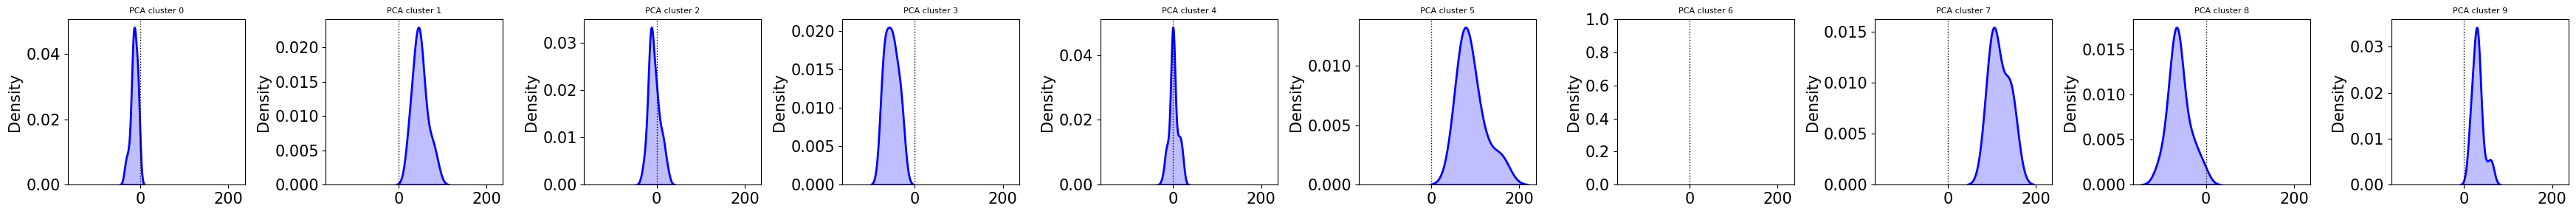

In [293]:
fig, axes = plt.subplots(1, n_clusters, figsize=(35,3), sharex=True) # , sharey=True)
axes= axes.ravel()

for j in range(n_clusters):
#     axes[j].hist(np.asarray(delta_ba)[kmeans_kp_pca==j], histtype='stepfilled')
    sns.distplot(np.asarray(delta_ba)[kmeans_kp_pca==j], ax=axes[j], hist=False, kde=True, 
            color = 'blue', 
            kde_kws = {'shade': True, 'linewidth': 2})
    axes[j].axvline(0, ls=':', c='k', lw=1)
    axes[j].set_title('PCA cluster {}'.format(j), fontsize=8)
    
plt.tight_layout()
fig.savefig(fish_paths[fish]/'kp_ba_{}.png'.format(n_clusters), dpi = 300)

## Eye clustering

In [106]:
cluster_n =[]
delta_body_angles= []
eye_angles_= []
bout_duration = 50

for i,on_ in enumerate(data['segments_on']):
        if (data['outlier'][i]<3)&(data['proba'][i]>0.4)&(on_+bout_duration<data['body_angle'].shape[0]):
            delta_body_angles.append((data['body_angle'][on_+bout_duration]-data['body_angle'][on_])*180/np.pi)
            left_eye = left_eye_vect[0,on_ :on_+bout_duration] -left_eye_vect[0,on_] 
            right_eye = right_eye_vect[0,on_ :on_+bout_duration]- right_eye_vect[0,on_]
            eye_angles_.append(np.concatenate([left_eye, right_eye]))
            cluster_n.append(data['bout_category_ts'][on_])

In [107]:
clusters_per_mov = np.asarray(cluster_n)
eye_comb = np.asarray(eye_angles_)
body_angles = np.asarray(delta_body_angles)

In [108]:
#Perform PCA
pca = PCA(n_components=25) #Start by looking at the firts 25 PCs.
pca.fit(eye_comb)

PCA(n_components=25)

In [109]:
#Define number of principal components based on the explained variance per PC above
n_components = 25
pca=PCA(n_components=n_components)
meanresps_pca=pca.fit_transform(eye_comb)

In [110]:
#Select number of clusters and clusterize
n_clusters = 10
kmeans_eye_pca = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(eye_comb)

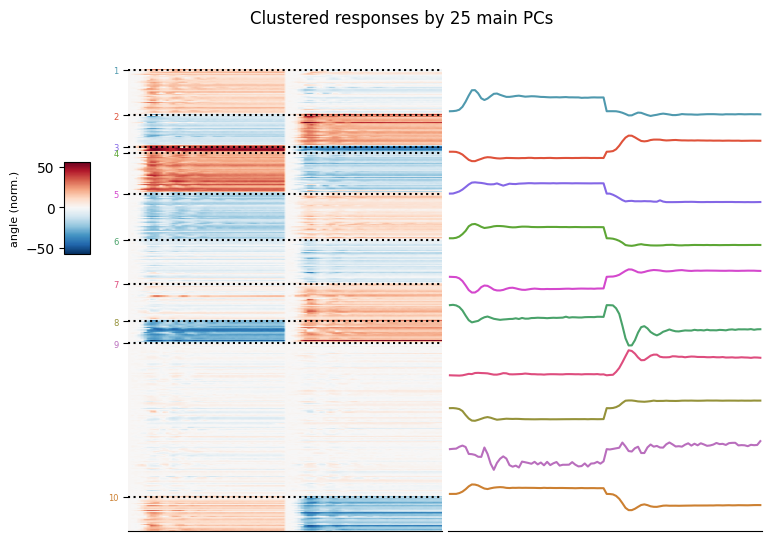

In [111]:
#Plot
cluster_fig = plt.figure(figsize=(9,6))

gs = gridspec.GridSpec(15,22)
gs.update(wspace=0.25, hspace=0)
ax1 = plt.subplot(gs[:, 2:12])
ax2 = plt.subplot(gs[:, 12:], sharex=ax1)
ax3 = plt.subplot(gs[3:6, 0:1])

heatmap = ax1.imshow(eye_comb[np.argsort(kmeans_eye_pca),:], aspect='auto', cmap='RdBu_r')#, vmin=-2.5, vmax=2.5)
unique, counts = np.unique(kmeans_eye_pca, return_counts=True)
yticks=[]
tick = 0

for cluster, roi_num in zip(unique, counts):
    yticks.append(tick)
    tick += counts[cluster]
ax1.set_xticks([])
ax1.set_yticks(yticks)
ax1.set_yticklabels(unique+1)
for tick in yticks:
    ax1.axhline(tick, ls=':', color='black')
    
for tick, col in zip(ax1.yaxis.get_major_ticks(), clust_colors):
    tick.label1.set_color(col)
    tick.label1.set_fontsize(6)

cluster, cells = np.unique(kmeans_eye_pca, return_counts=True)
cluster_roi_count = dict(zip(cluster, cells))

for cluster, color in zip(np.unique(kmeans_eye_pca), clust_colors):
        ax2.plot(nanzscore(eye_comb[kmeans_eye_pca==cluster,:].mean(0))-cluster*5, c=color, label=cluster)
ax2.set_xticks([])
ax2.set_xticks([])
ax2.set_yticks([])


sns.despine(left=True)
cluster_fig.suptitle('Clustered responses by {} main PCs'.format(n_components))

plt.colorbar(heatmap, cax=ax3)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_ylabel('angle (norm.)', fontsize=8)
ax3.yaxis.set_label_position('left')
ax3.yaxis.tick_left()

plt.tight_layout()
cluster_fig.savefig(fish_paths[fish]/'eyes_clustering_{}.png'.format(n_clusters), dpi = 300)

## Matrix of eye vs bout cluster

In [112]:
clusters_per_eye_cluster = []
for i, cluster in enumerate(range(n_clusters)):
    mask = np.argwhere(kmeans_eye_pca==cluster)
    clusters_per_eye_cluster.append(clusters_per_mov[mask])

clusters_per_eye_cluster_flat =[]
for i in range(len(clusters_per_eye_cluster)):
    clusters_per_eye_cluster_flat.append(np.asarray(list(itertools.chain(*clusters_per_eye_cluster[i]))))

In [113]:
# np.digitize(clusters_per_eye_cluster_flat[0], np.arange(0, len(NameCat),1))
tmp = np.zeros((n_clusters, len(NameCat)))

for i in range(n_clusters):
    unique, counts = np.unique(clusters_per_eye_cluster_flat[i], return_counts=True)
    for ind, item in enumerate(unique):
        tmp[i,int(item)] = counts[ind]


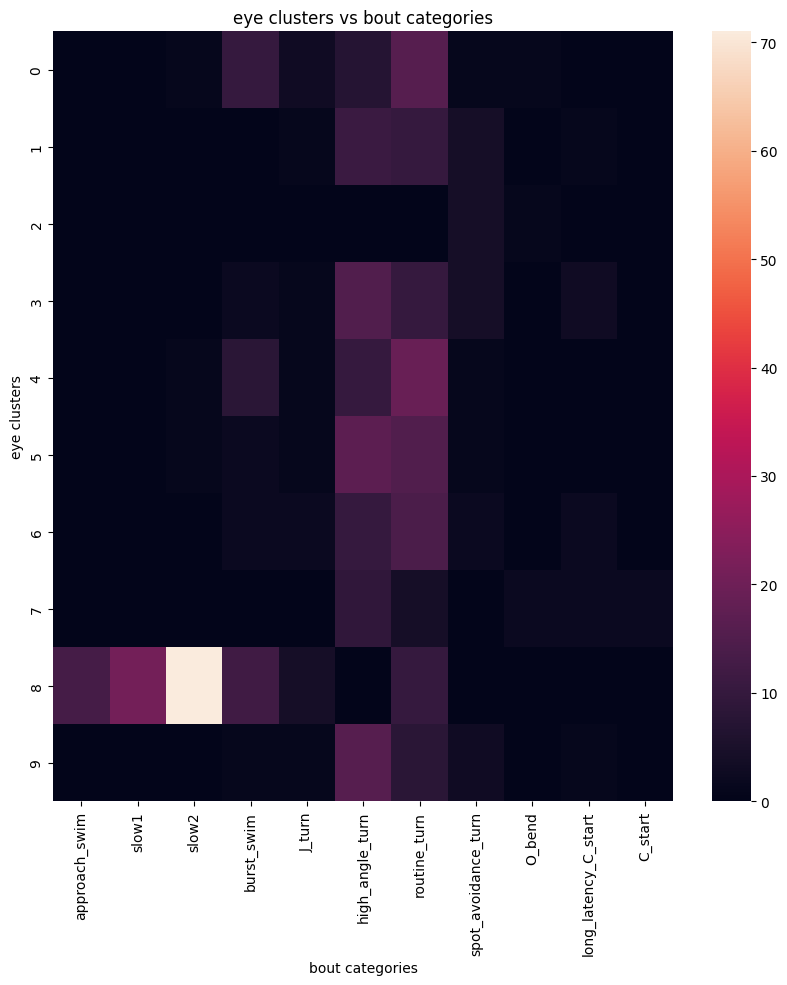

In [115]:
# Create a dataset
data_heatmap = pd.DataFrame(tmp, columns=NameCat)

# 3. Plot the heatmap
plt.figure(figsize=(10,10))
p1 = sns.heatmap(data_heatmap) #, annot=True, annot_kws={"size": 7})
plt.title( "eye clusters vs bout categories" )
plt.ylabel('eye clusters')
plt.xlabel('bout categories')

plt.savefig(fish_paths[fish]/'eye_heatmap_{}.png'.format(n_clusters), dpi = 300)

### Barplots

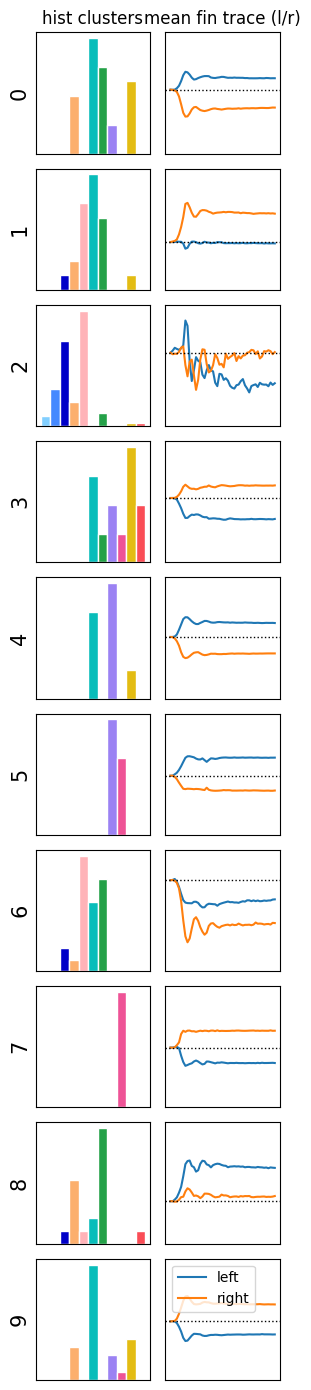

In [176]:
color = cfg_classify.bouts_dict['color']
fig, axes = plt.subplots(n_clusters, 2, figsize=(3, 14))
# axes= axes.ravel()

for i, cluster in enumerate(range(n_clusters)):
    mask = np.argwhere(kmeans_eye_pca==cluster)
    n, bins, patches = axes[i,0].hist(clusters_per_mov[mask], bins=np.arange(0,12,1),
                            density=False, edgecolor='white', linewidth=1)
    axes[i, 0].set_ylabel('{}'.format(cluster))
    axes[i, 0].set_yticks([])
    axes[i, 0].set_xticks([])
    for j in range(len(bins)-1):
        patches[j].set_facecolor(color[j])
        
    axes[i,1].plot(nanzscore(eye_comb[kmeans_eye_pca==cluster,:].mean(0))[:50], label='left')
    axes[i,1].plot(nanzscore(eye_comb[kmeans_eye_pca==cluster,:].mean(0))[50:], label='right')
    axes[i,1].axhline(nanzscore(eye_comb[kmeans_eye_pca==cluster,:].mean(0))[:50][0], ls=':', color='black', lw=1)
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    axes[i,1].set_ylim(-4,4)

plt.legend()
    
axes[0, 0].set_title('hist clusters')
axes[0, 1].set_title('mean fin trace (l/r)')
# axes[n_clusters-1, 0].set_xticks(bins + 0.5, labels = labels_cat[:12], fontsize=5)

plt.tight_layout()
fig.savefig(fish_paths[fish]/'eye_clustering_hist_{}.png'.format(n_clusters), dpi = 300)

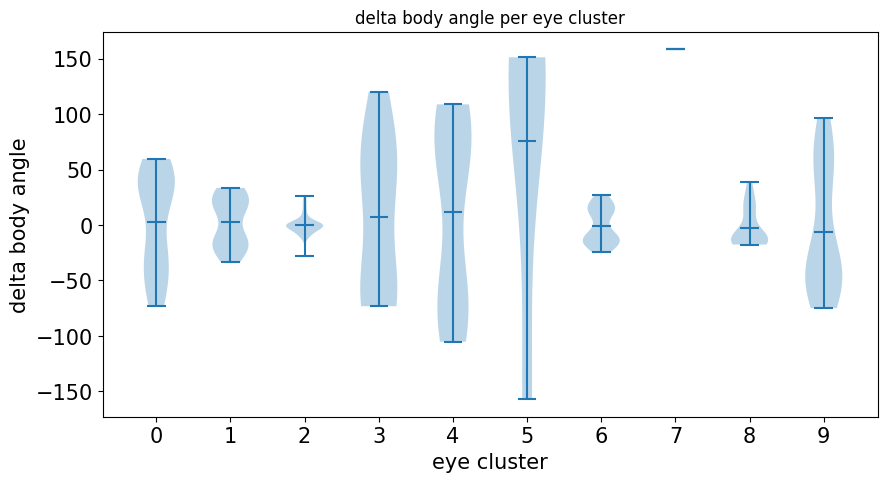

In [177]:
violin_angles = []

for i in range(n_clusters):
    coll= []
    mask = np.argwhere(kmeans_eye_pca==i)
    coll.append(body_angles[mask])
    violin_angles.append(coll)
    
pos = np.arange(0, n_clusters, 1)

violin_angles_flat = [item for sublist in violin_angles for item in sublist]

violin_angles_flat2 =[]
for i in range(len(violin_angles_flat)):
    violin_angles_flat2.append(list(itertools.chain(*violin_angles_flat[i])))

plt.figure(figsize=(10,5))
plt.violinplot(violin_angles_flat2, pos,vert=True, showmeans=True)
plt.xticks(np.arange(0, n_clusters,1))
plt.xlabel('eye cluster')
plt.ylabel('delta body angle')
plt.title('delta body angle per eye cluster')
plt.savefig(fish_paths[fish]/'body_angle_clustr_eye.png', dpi = 300)

In [178]:
Ei =[]
dislocs = []
for i in range(n_clusters):
    cumsums=[]
    ammpls =[]
    ml =nanzscore(eye_comb[kmeans_eye_pca==i,:50])- nanzscore(eye_comb[kmeans_eye_pca==i,:50][0])
    mr =nanzscore(eye_comb[kmeans_eye_pca==i,50:])- nanzscore(eye_comb[kmeans_eye_pca==i,50:][0])
    for j in range(len(ml)):
        cumsums.append(np.cumsum(abs(mr[j][1:]),axis=0)[-1] -np.cumsum(abs(ml[j][1:]),axis=0)[-1])
        ammpls.append([np.max(abs(mr[j][1:])), np.max(abs(ml[j][1:]))])
        
    Ei.append(cumsums) #normalizing?
    dislocs.append(ammpls)#left, right


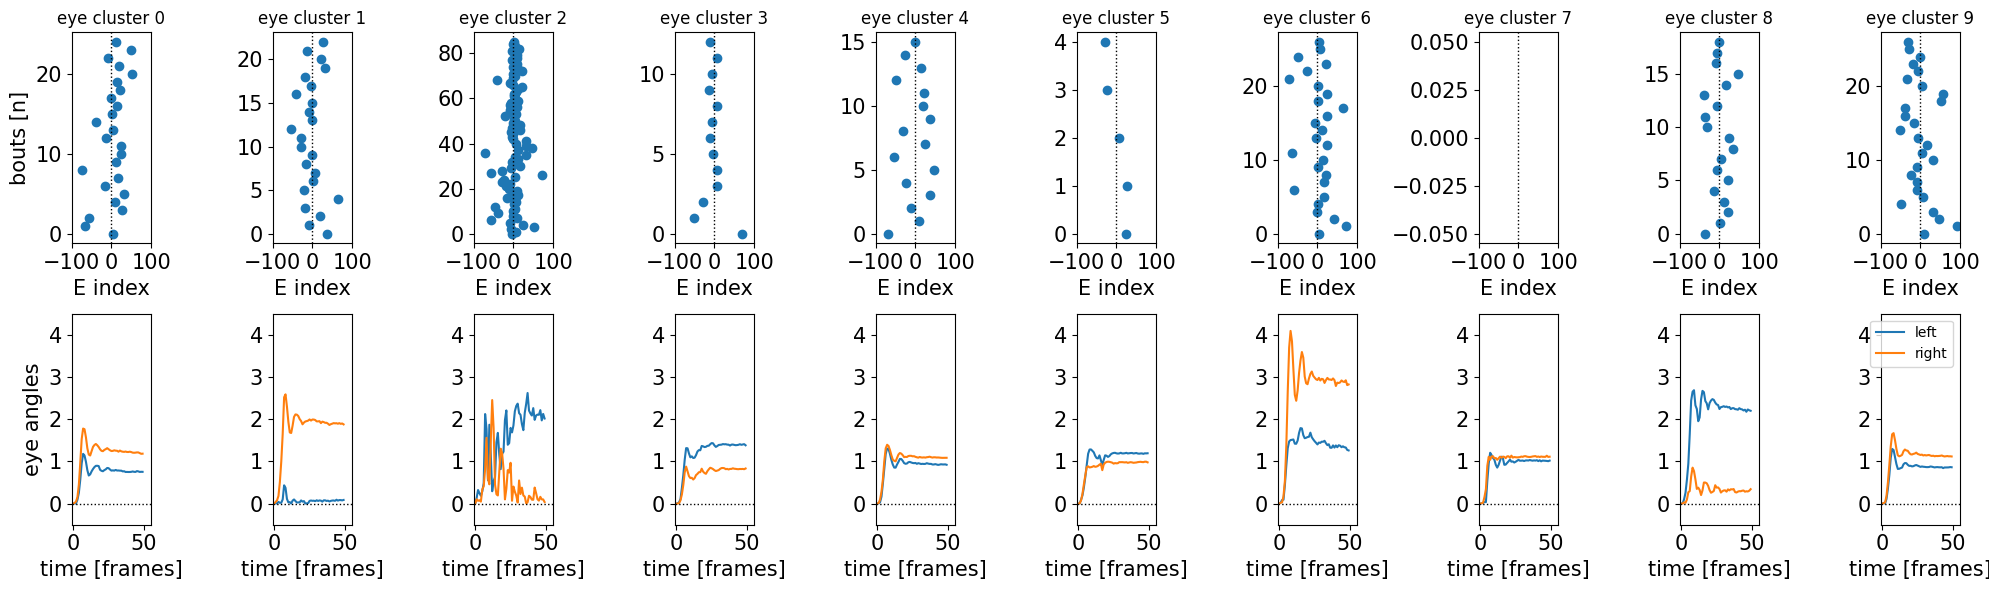

In [182]:
Fig, axes = plt.subplots(2 ,n_clusters, figsize=(20,6))
axes= axes.ravel()

for i in range(n_clusters):
    mask = np.argwhere(kmeans_eye_pca==i)
    trials = np.arange(0, len(Ei[i]), 1)
    axes[i].scatter(Ei[i], trials)
#     axes[i].scatter(Ei1[i], 1, c='r')
    axes[i].set_title('eye cluster {}'.format(i))
    axes[i].set_xlabel('E index')
    axes[i].set_xlim(-100,100)
    axes[i].axvline(0, ls=':', color='black', lw=1)

for i in range(n_clusters):
    axes[i + n_clusters].plot(abs(nanzscore(eye_comb[kmeans_eye_pca==i,:].mean(0))[:50]- nanzscore(eye_comb[kmeans_eye_pca==i,:].mean(0))[:50][0]), label='left')
    axes[i + n_clusters].plot(abs(nanzscore(eye_comb[kmeans_eye_pca==i,:].mean(0))[50:]- nanzscore(eye_comb[kmeans_eye_pca==i,:].mean(0))[50:][0]), label='right')
    axes[i + n_clusters].axhline(0, ls=':', color='black', lw=1)
    axes[i + n_clusters].set_xticks(np.linspace(0,50, 2))
    axes[i + n_clusters].set_xlim(-1,55)
    axes[i + n_clusters].set_ylim(-0.5,4.5)
    axes[i + n_clusters].set_xlabel('time [frames]')
    
axes[0].set_ylabel('bouts [n]')
axes[0 + n_clusters].set_ylabel('eye angles')
axes[-1].legend()
plt.tight_layout()
fig.savefig(fish_paths[fish]/'eye_trial_Ei.png', dpi = 350)

## Todos from Meeting (30/03/2023):

    *which ones move first- fin, eyes or tail?
    *
    *
    *

### Violin plot of bout angles

In [203]:
violin_angles = []

for i in range(n_clusters):
    coll= []
    mask = np.argwhere(kmeans_fins_pca==i)
    coll.append(body_angles[mask])
    violin_angles.append(coll)
    
pos = np.arange(0, n_clusters, 1)

In [204]:
violin_angles_flat = [item for sublist in violin_angles for item in sublist]

violin_angles_flat2 =[]
for i in range(len(violin_angles_flat)):
    violin_angles_flat2.append(list(itertools.chain(*violin_angles_flat[i])))

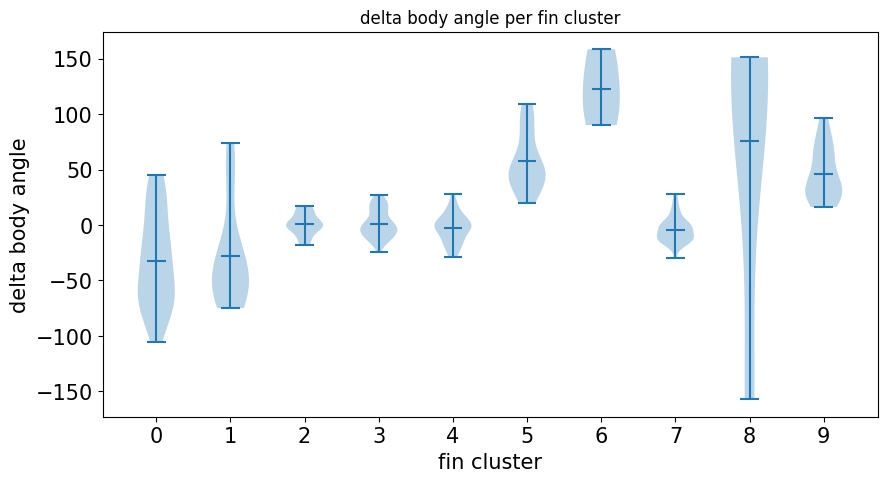

In [205]:
plt.figure(figsize=(10,5))
plt.violinplot(violin_angles_flat2, pos,vert=True, showmeans=True)
plt.xticks(np.arange(0, n_clusters,1))
plt.xlabel('fin cluster')
plt.ylabel('delta body angle')
plt.title('delta body angle per fin cluster')
plt.savefig(fish_paths[fish]/'body_angle_clustr.png', dpi = 300)

## Oscilaltion or steering?

- get freq
- look at dislocation from baseline for steering

#### On the means to develop the index and a feeling for it

In [206]:
Ei1 =[]
dislocs1 = []
for i in range(n_clusters):
    ml = nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50][0]
    mr = nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:][0]
    Ei1.append(np.cumsum(abs(mr))[-1] - np.cumsum(abs(ml))[-1])
    dislocs1.append([np.max(abs(mr)), np.max(abs(ml))])#right, left

#### For all bouts

In [207]:
Ei =[]
dislocs = []
for i in range(n_clusters):
    cumsums=[]
    ammpls =[]
    ml =nanzscore(fins_comb[kmeans_fins_pca==i,:50])- nanzscore(fins_comb[kmeans_fins_pca==i,:50][0])
    mr =nanzscore(fins_comb[kmeans_fins_pca==i,50:])- nanzscore(fins_comb[kmeans_fins_pca==i,50:][0])
    for j in range(len(ml)):
        cumsums.append(np.cumsum(abs(mr[j][1:]),axis=0)[-1] -np.cumsum(abs(ml[j][1:]),axis=0)[-1])
        ammpls.append([np.max(abs(mr[j][1:])), np.max(abs(ml[j][1:]))])
        
    Ei.append(cumsums) #normalizing?
    dislocs.append(ammpls)#left, right


#### Relationship between fin max movement and velocity?

In [208]:
# velo_n, tailsum_n
velo_n = np.asarray(velo_n)
mask = np.argwhere(kmeans_fins_pca==0)
velo_n[mask].shape, np.asarray(dislocs[0]).shape, mask.shape

((26, 1, 50), (26, 2), (26, 1))

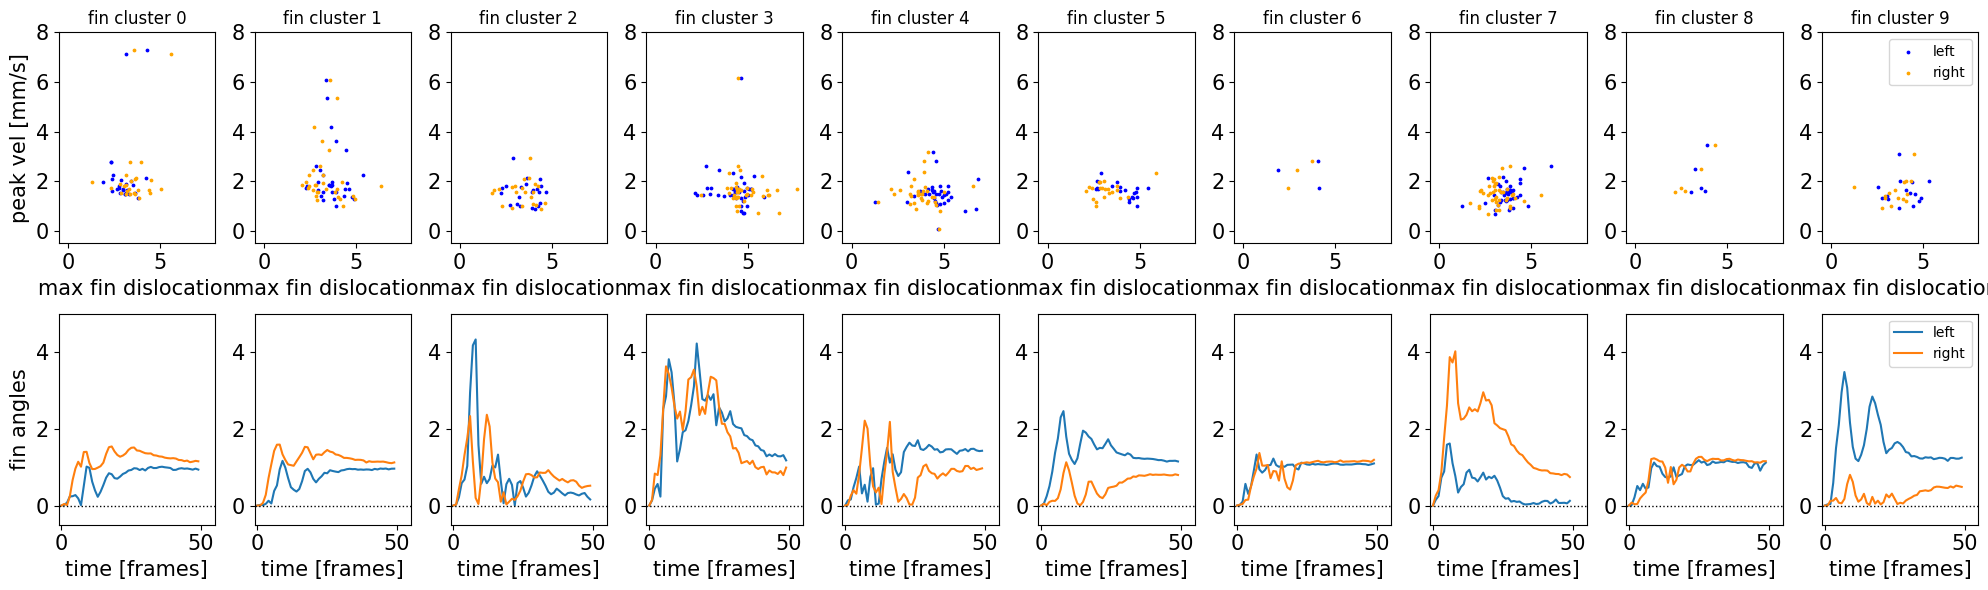

In [211]:
fig, axes = plt.subplots(2 ,n_clusters, figsize=(20,6))
axes= axes.ravel()

for i in range(n_clusters):
    mask = np.argwhere(kmeans_fins_pca==i)
    axes[i].scatter( np.asarray(dislocs[i])[:, 1], np.max(velo_n[mask], axis=2), c='blue', s=3, label ='left')
    axes[i].scatter( np.asarray(dislocs[i])[:, 0], np.max(velo_n[mask], axis=2), c='orange', s=3, label ='right')
    axes[i].set_ylim(-0.5,8)
    axes[i].set_xlim(-0.5,8)
    axes[i].set_xlabel('max fin dislocation')
    axes[i].set_title('fin cluster {}'.format(i))

for i in range(n_clusters):
    axes[i + n_clusters].plot(abs(nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50][0]), label='left')
    axes[i + n_clusters].plot(abs(nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:][0]), label='right')
    axes[i + n_clusters].axhline(0, ls=':', color='black', lw=1)
    axes[i + n_clusters].set_xticks(np.linspace(0,50, 2))
    axes[i + n_clusters].set_xlim(-1,55)
    axes[i + n_clusters].set_ylim(-0.5,5)
    axes[i + n_clusters].set_xlabel('time [frames]')
    
axes[0].set_ylabel('peak vel [mm/s]')
axes[0 + n_clusters].set_ylabel('fin angles')
axes[-1].legend()
axes[9].legend()

plt.tight_layout()
fig.savefig(fish_paths[fish]/'fins_velo.png', dpi = 350)


#### How does Ei look in each trial?

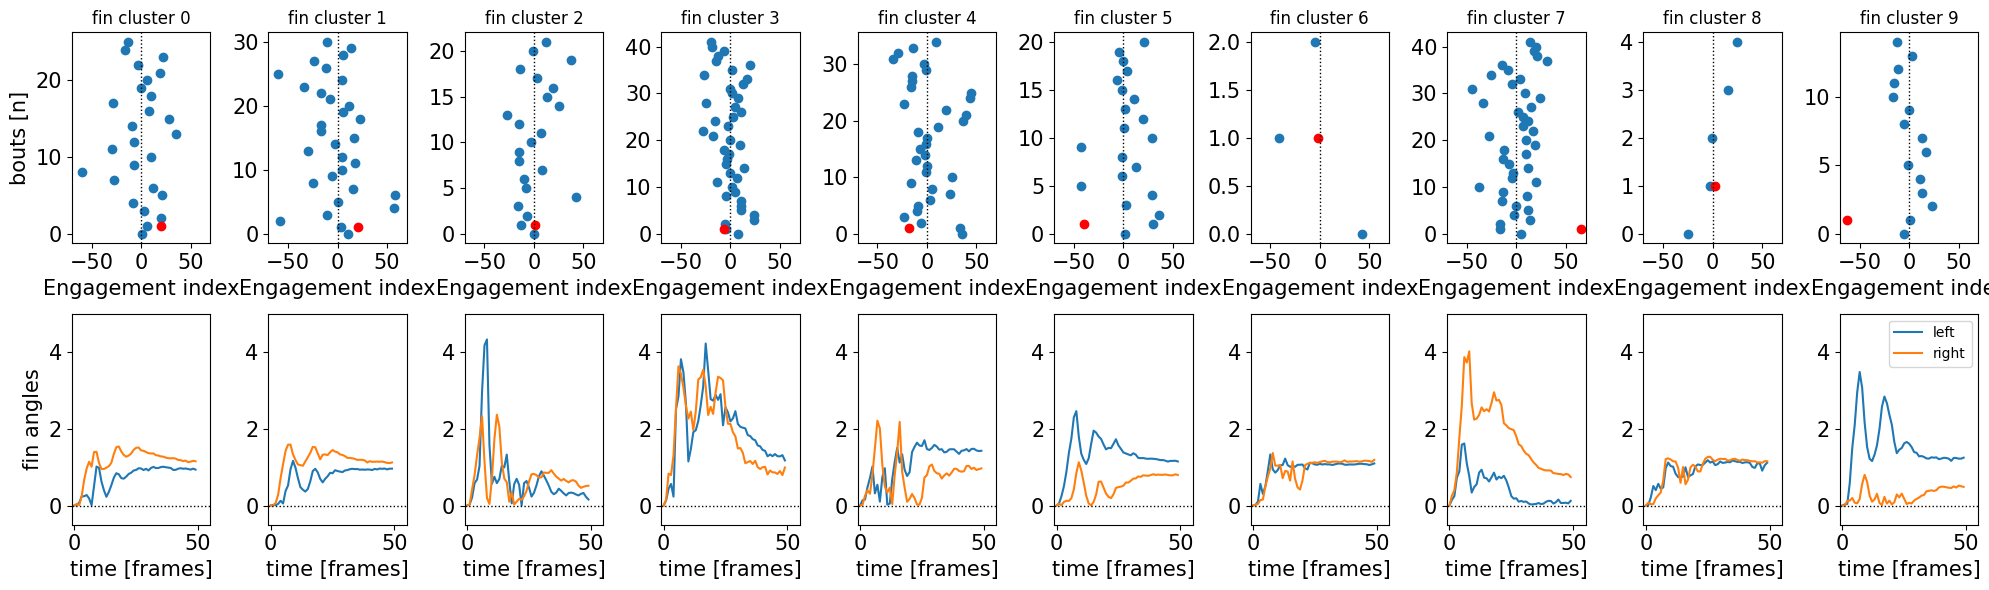

In [214]:
fig, axes = plt.subplots(2 ,n_clusters, figsize=(20,6))
axes= axes.ravel()

for i in range(n_clusters):
    mask = np.argwhere(kmeans_fins_pca==i)
    trials = np.arange(0, len(Ei[i]), 1)
    axes[i].scatter(Ei[i], trials)
    axes[i].scatter(Ei1[i], 1, c='r')
    axes[i].set_title('fin cluster {}'.format(i))
    axes[i].set_xlabel('Engagement index')
    axes[i].set_xlim(-70,70)
    axes[i].axvline(0, ls=':', color='black', lw=1)

for i in range(n_clusters):
    axes[i + n_clusters].plot(abs(nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50][0]), label='left')
    axes[i + n_clusters].plot(abs(nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:][0]), label='right')
    axes[i + n_clusters].axhline(0, ls=':', color='black', lw=1)
    axes[i + n_clusters].set_xticks(np.linspace(0,50, 2))
    axes[i + n_clusters].set_xlim(-1,55)
    axes[i + n_clusters].set_ylim(-0.5,5)
    axes[i + n_clusters].set_xlabel('time [frames]')
    
axes[0].set_ylabel('bouts [n]')
axes[0 + n_clusters].set_ylabel('fin angles')
axes[-1].legend()
plt.tight_layout()
fig.savefig(fish_paths[fish]/'fins_trial_Ei.png', dpi = 350)

#### Relationshop between Ei and body angle?

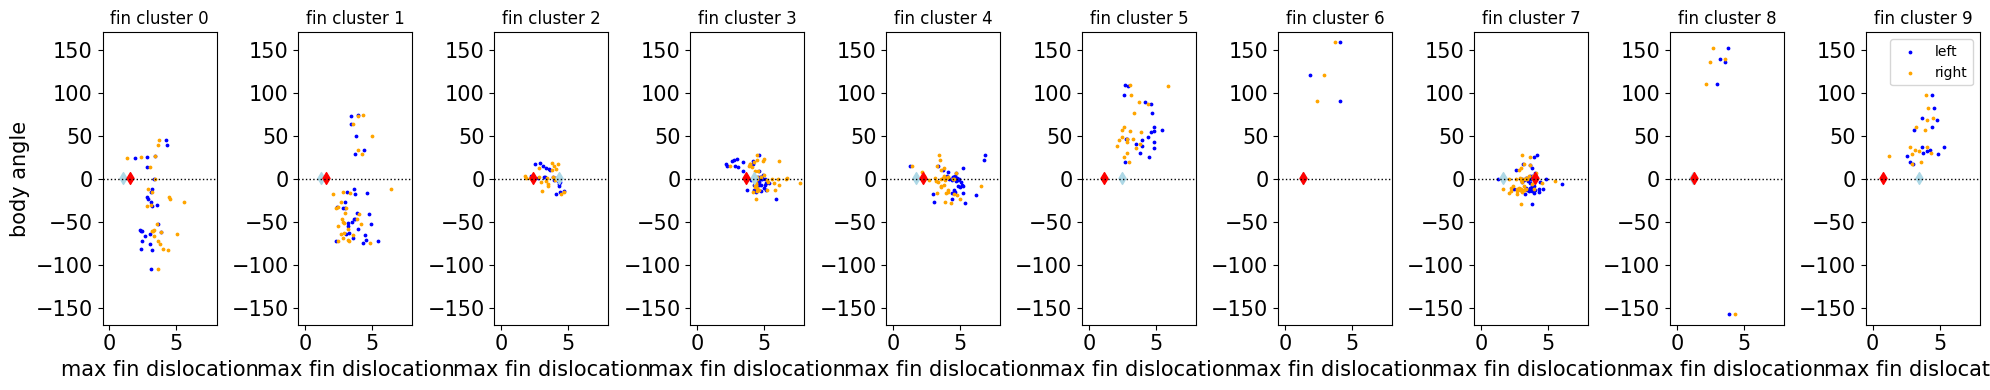

In [215]:
fig, axes = plt.subplots(1,n_clusters, figsize=(20,4))
axes= axes.ravel()

for i in range(n_clusters):
    mask = np.argwhere(kmeans_fins_pca==i)
    axes[i].scatter( np.asarray(dislocs[i])[:, 1], body_angles[mask], c='blue', s=3, label ='left')
    axes[i].scatter( np.asarray(dislocs[i])[:, 0], body_angles[mask], c='orange', s=3, label ='right')

    axes[i].scatter( np.asarray(dislocs1[i][1]), 1,  marker="d", c='lightblue')
    axes[i].scatter( np.asarray(dislocs1[i][0]), 1,  marker="d", c='red')
    axes[i].set_ylim(-170,170)
    axes[i].set_xlim(-0.5,8)
    axes[i].set_xlabel('max fin dislocation')
    axes[i].set_title('fin cluster {}'.format(i))
    axes[i].axhline(0, ls=':', color='black', lw=1)
    
axes[0].set_ylabel('body angle')
axes[-1].legend()
plt.tight_layout()

fig.savefig(fish_paths[fish]/'fins_body_angle_Ei.png', dpi = 350)


## Phase antiphase?
https://stackoverflow.com/questions/6157791/find-phase-difference-between-two-inharmonic-waves

In [216]:
corrs= []
for i in range(n_clusters):
    ml = nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50][0]
    mr = nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:][0]
    corrs.append(correlate(ml, mr))

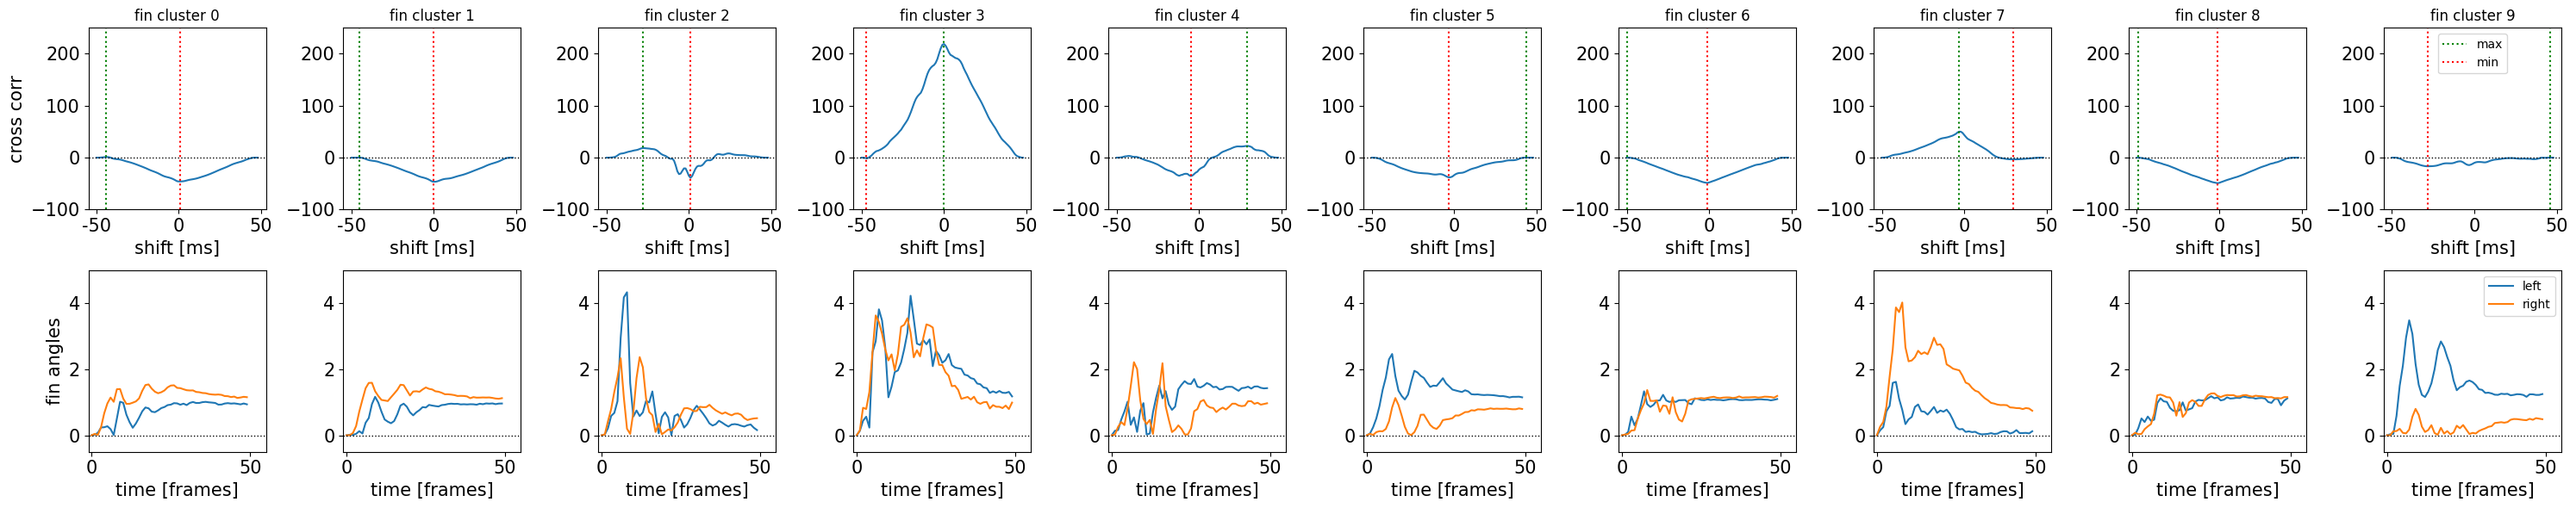

In [217]:
fig, axes = plt.subplots(2 ,n_clusters, figsize=(30,6))
axes= axes.ravel()

for i in range(n_clusters):
    mask = np.argwhere(kmeans_fins_pca==i)
    axes[i].plot(corrs[i])
    axes[i].axhline(0, ls=':', color='black', lw=1)
    axes[i].set_xlabel('shift [ms]')
    axes[i].axvline(np.argmax(corrs[i]), ls=':', c='g', label='max')
    axes[i].axvline(np.argmin(corrs[i]), ls=':', c='r', label='min')
    axes[i].set_title('fin cluster {}'.format(i))
    axes[i].set_xticks([0, 50, 100])
    axes[i].set_xticklabels([-50, 0, 50]) #np.arange(-75, 75, 10))
    axes[i].set_ylim(-100,250)
    
for i in range(n_clusters):
    axes[i + n_clusters].plot(abs(nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50][0]), label='left')
    axes[i + n_clusters].plot(abs(nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:][0]), label='right')
    axes[i + n_clusters].axhline(0, ls=':', color='black', lw=1)
    axes[i + n_clusters].set_xticks(np.linspace(0,50, 2))
    axes[i + n_clusters].set_xlim(-1,55)
    axes[i + n_clusters].set_ylim(-0.5,5)
    axes[i + n_clusters].set_xlabel('time [frames]')
    
axes[0].set_ylabel('cross corr')
axes[0 + n_clusters].set_ylabel('fin angles')
axes[-1].legend()
axes[9].legend()

plt.tight_layout()
fig.savefig(fish_paths[fish]/'fins_corr.png', dpi = 350)

## Master plot

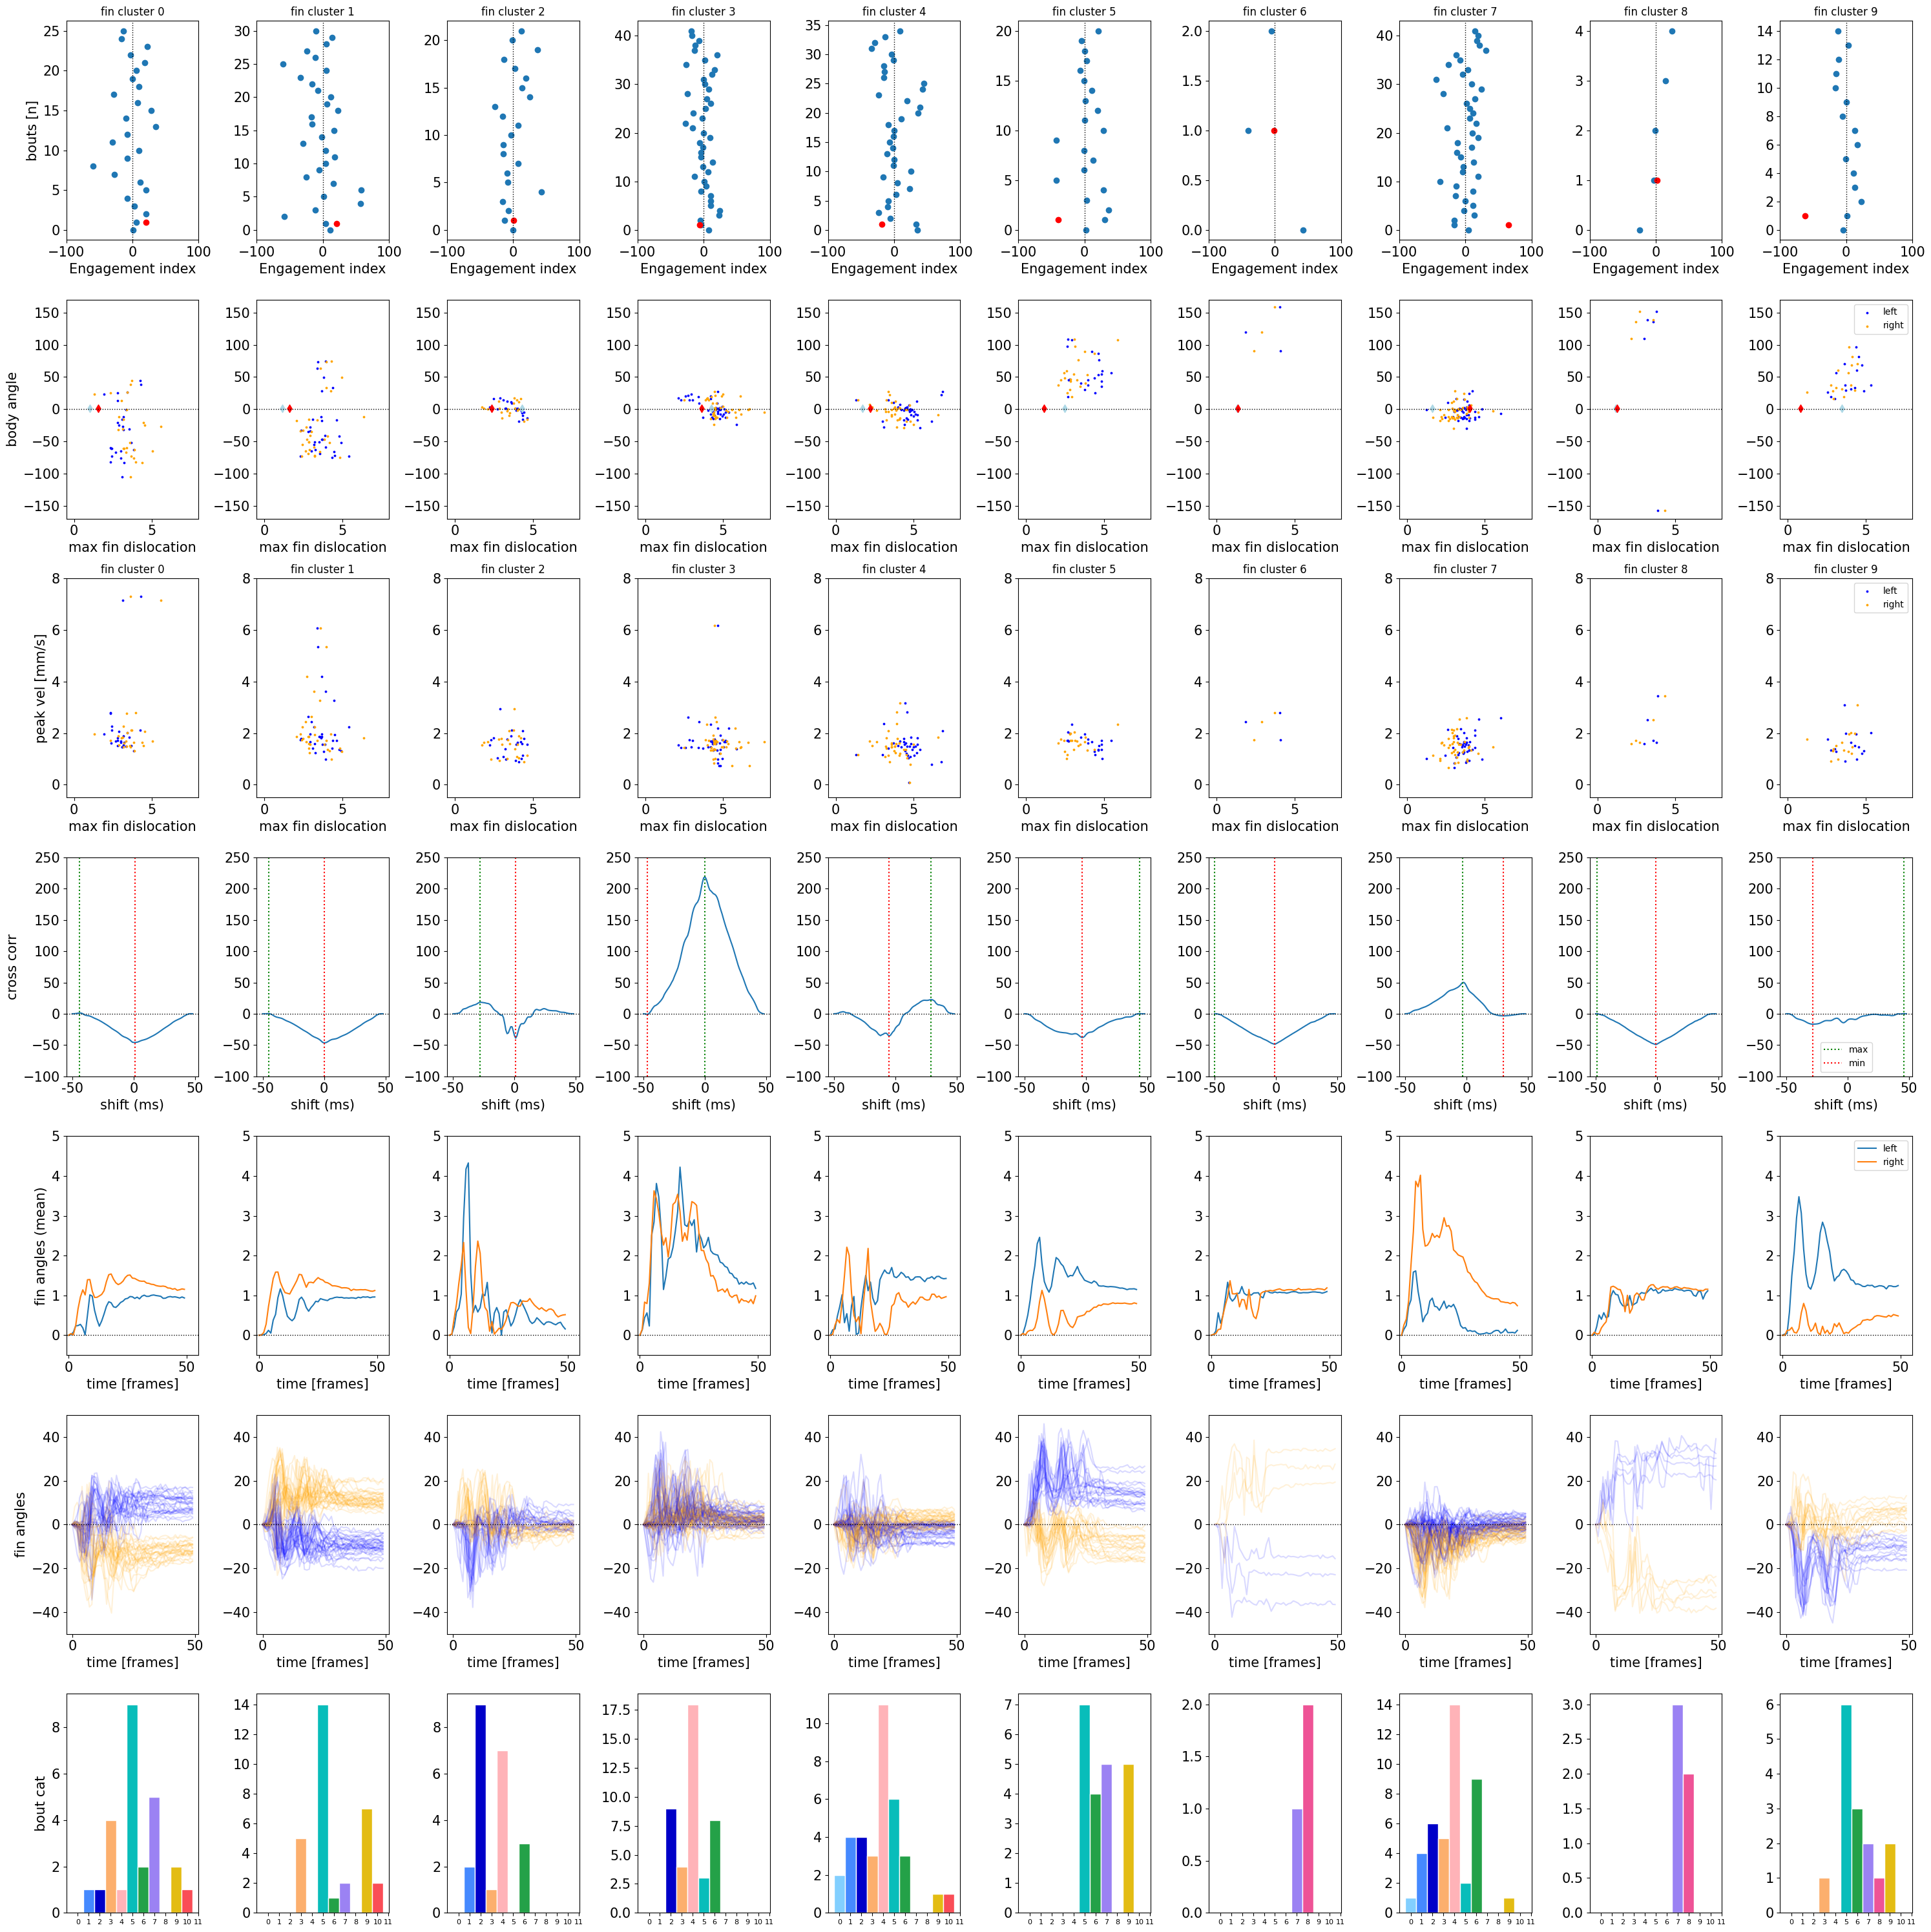

In [219]:
fig, axes = plt.subplots(7,n_clusters, figsize=(30,30))
axes= axes.ravel()

for i in range(n_clusters):
    mask = np.argwhere(kmeans_fins_pca==i)
    trials = np.arange(0, len(Ei[i]), 1)
    axes[i].scatter(Ei[i], trials)
    axes[i].scatter(Ei1[i], 1, c='r')
    
    axes[i].set_title('fin cluster {}'.format(i))
    axes[i].set_xlabel('Engagement index')
    axes[i].set_xlim(-100,100)
    axes[i].axvline(0, ls=':', color='black', lw=1)
    
for i in range(n_clusters):
    mask = np.argwhere(kmeans_fins_pca==i)
    axes[i+ n_clusters].scatter( np.asarray(dislocs[i])[:, 1], body_angles[mask], c='blue', s=3, label ='left')
    axes[i+ n_clusters].scatter( np.asarray(dislocs[i])[:, 0], body_angles[mask], c='orange', s=3, label ='right')

    axes[i+ n_clusters].scatter( np.asarray(dislocs1[i][1]), 1,  marker="d", c='lightblue')
    axes[i+ n_clusters].scatter( np.asarray(dislocs1[i][0]), 1,  marker="d", c='red')
    axes[i+ n_clusters].set_ylim(-170,170)
    axes[i+ n_clusters].set_xlim(-0.5,8)
    axes[i+ n_clusters].set_xlabel('max fin dislocation')
    axes[i+ n_clusters].axhline(0, ls=':', color='black', lw=1)
    
for i in range(n_clusters):
    mask = np.argwhere(kmeans_fins_pca==i)
    axes[i + n_clusters*2].scatter( np.asarray(dislocs[i])[:, 1], np.max(velo_n[mask], axis=2), c='blue', s=3, label ='left')
    axes[i + n_clusters*2].scatter( np.asarray(dislocs[i])[:, 0], np.max(velo_n[mask], axis=2), c='orange', s=3, label ='right')

    axes[i + n_clusters*2].set_ylim(-0.5,8)
    axes[i + n_clusters*2].set_xlim(-0.5,8)
    axes[i + n_clusters*2].set_xlabel('max fin dislocation')
    axes[i + n_clusters*2].set_title('fin cluster {}'.format(i))

    
for i in range(n_clusters):
    mask = np.argwhere(kmeans_fins_pca==i)
    axes[i+ n_clusters*3].plot(corrs[i])
    axes[i+ n_clusters*3].axhline(0, ls=':', color='black', lw=1)
    axes[i+ n_clusters*3].set_xticks([0, 50, 100])
    axes[i+ n_clusters*3].set_xticklabels([-50, 0, 50]) #np.arange(-75, 75, 10))
    axes[i+ n_clusters*3].set_ylim(-100,250)
    axes[i+ n_clusters*3].set_xlabel('shift (ms)')

    axes[i+ n_clusters*3].axvline(np.argmax(corrs[i]), ls=':', c='g', label='max')
    axes[i+ n_clusters*3].axvline(np.argmin(corrs[i]), ls=':', c='r', label='min')
    

for i in range(n_clusters):
    axes[i + n_clusters*4].plot(abs(nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[:50][0]), label='left')
    axes[i + n_clusters*4].plot(abs(nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:]- nanzscore(fins_comb[kmeans_fins_pca==i,:].mean(0))[50:][0]), label='right')
    axes[i + n_clusters*4].axhline(0, ls=':', color='black', lw=1)
    axes[i + n_clusters*4].set_xticks(np.linspace(0,50, 2))
    axes[i + n_clusters*4].set_xlim(-1,55)
    axes[i + n_clusters*4].set_ylim(-0.5,5)
    axes[i + n_clusters*4].set_xlabel('time [frames]')
    
for i in range(n_clusters):
    for bout in fins_comb[kmeans_fins_pca==i,:]:
        axes[i + n_clusters*5].plot(bout[:50]- bout[0], alpha=0.15, c='blue', label='left')
        axes[i + n_clusters*5].plot(bout[50:]- bout[50], alpha=0.15, c='orange', label='right')
    axes[i + n_clusters*5].axhline(0, ls=':', color='black', lw=1)
    axes[i + n_clusters*5].set_xticks(np.linspace(0,50, 2))
    axes[i + n_clusters*5].set_ylim(-50,50)
    axes[i + n_clusters*5].set_xlabel('time [frames]')
    
    
for i, cluster in enumerate(range(n_clusters)):
    mask = np.argwhere(kmeans_fins_pca==cluster)
    n, bins, patches = axes[i + n_clusters*6].hist(clusters_per_mov[mask], bins=np.arange(0,12,1),
                            density=False, edgecolor='white', linewidth=1)

    axes[i + n_clusters*6].set_xticks([])
    for j in range(len(bins)-1):
        patches[j].set_facecolor(color[j])
    axes[i + n_clusters*6].set_xticks(bins + 0.5, labels = np.arange(0,12,1), fontsize=8)
    
    
axes[0].set_ylabel('bouts [n]')
axes[0 + n_clusters].set_ylabel('body angle')
axes[0 + n_clusters*2].set_ylabel('peak vel [mm/s]')
axes[0 + n_clusters*3].set_ylabel('cross corr')
axes[0 + n_clusters*4].set_ylabel('fin angles (mean)')
axes[0 + n_clusters*5].set_ylabel('fin angles')
axes[0 + n_clusters*6].set_ylabel('bout cat')

axes[19].legend()
axes[29].legend()
axes[39].legend()
axes[49].legend()

plt.tight_layout()

fig.savefig(fish_paths[fish]/'fins_body_angle_coord.png', dpi = 300)